# K-Means

In [1]:
from typing import Union, Literal
import time
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

In [2]:
class KMeans:
    """
    Perform KMeans clustering on a dataset.
    """

    def __init__(self,
                 algorithm : Literal['lloyd', 'extended-hartigan', 'safe-hartigan', 'hartigan', 'binary-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'] = 'lloyd',
                 init : Literal['random', 'random-data', 'k-means++', 'maximin', 'greedy-k-means++'] = 'random',
                 seed : Union[int, None] = None):
        """
        Initialize the KMeans object.

        Parameters
        ----------
        algorithm : {'lloyd', 'extended-hartigan', 'safe-hartigan', 'hartigan', 'binary-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'}
            Algorithm to use. Either 'lloyd' or 'extended-hartigan' or 'safe-hartigan' or 'hartigan' or 'binary-hartigan'

        init : {'random', 'random-data', 'k-means++', 'maximin', 'greedy-k-means++'}
            Initialization method. Either 'random' or 'random-data' or 'k-means++' or 'maximin' or 'greedy-k-means++'

        seed : int
            Seed for random generator
        """

        assert algorithm in ['lloyd', 'extended-hartigan', 'safe-hartigan', 'hartigan', 'binary-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], "algorithm must be either 'lloyd', 'extended-hartigan', 'safe-hartigan', 'hartigan', 'binary-hartigan', 'mixed-hartigan' or 'mixed-extended-hartigan'"
        assert init in ['random', 'random-data', 'k-means++', 'maximin', 'greedy-k-means++'], "init must be either 'random', 'random-data', 'k-means++', 'maximin', or 'greedy-k-means++'"
        assert seed is None or isinstance(seed, int), "seed must be an int or None"

        self.algorithm = algorithm
        self.init = init
        self.seed = seed

        self.data = None
        self.k = None
        self.n_samples = None
        self.centroids = None
        self.y_pred = None

        self.safe_iterations = 0
        self.unsafe_iterations = 0
        self.lloyd_iterations = 0
        self.hartigan_iterations = 0
        self.binary_iterations = 0

        self.norm_calculations = 0
        self.init_norm_calculations = 0


    def fit(self, data : np.ndarray, k : int, debug : int = 0):
        """
        Fit the model to the data.

        Parameters
        ----------
        data : np.ndarray
            nxd DataFrame of n samples with d features
        k : int
            Number of clusters
        debug : int
            Debug level (0: no debug, 1: some debug, 2: all debug)

        Returns
        -------
        np.ndarray
            Array of shape (k, d) with cluster centroids
        np.ndarray
            Array of length n with cluster assignments for each sample
        """

        assert isinstance(data, np.ndarray), "data must be a numpy array"
        assert len(data.shape) == 2, "data must be a 2D array"
        assert isinstance(k, int), "k must be an int"
        assert 0 < k <= len(data), "k must be at least 0 and at most the number of samples"
        assert isinstance(debug, int) or debug, "debug must be an int"

        self.data = data
        self.k = k
        self.n_samples = data.shape[0]

        np.random.seed(self.seed)

        # initialize centroids
        self._init_centroids(debug)
        debug and print('initial centroids:\n', self.centroids)
        debug and print('initial y_pred:', self.y_pred)

        if self.algorithm == 'lloyd':
            self._lloyd(debug)
        elif self.algorithm == 'extended-hartigan':
            self._extended_hartigan(always_safe=False, debug=debug)
        elif self.algorithm == 'safe-hartigan':
            self._extended_hartigan(always_safe=True, binary_hartigan=False, debug=debug)
        elif self.algorithm == 'binary-hartigan':
            self._extended_hartigan(always_safe=False, binary_hartigan=True, debug=debug)
        elif self.algorithm == 'hartigan':
            self._hartigan(debug)
        elif self.algorithm == 'mixed-hartigan':
            self._lloyd(debug)
            self._hartigan(debug)
        elif self.algorithm == 'mixed-extended-hartigan':
            self._lloyd(debug)
            self._extended_hartigan(always_safe=False, binary_hartigan=False, debug=debug)
        
        debug and print('final centroids:\n', self.centroids)
        debug and print('final y_pred:', self.y_pred)


    def _init_centroids(self, debug=0):
        """
        Initialize the centroids.
        """

        if self.init == 'random':

            # choose k random data points as initial centroids
            idx = np.random.choice(self.n_samples, self.k, replace=False)
            self.centroids = self.data[idx]
            self.y_pred = self._assign_clusters(debug=debug>1, init_call=True)

        elif self.init == 'random-data':
            return NotImplemented
            
            # V1
            # assign each data point to a random cluster
            clusters = np.random.choice(self.k, self.n_samples)

            # check that at least one point is assigned to each cluster
            while len(set(clusters)) < self.k:
                clusters = np.random.choice(self.k, self.n_samples)
            self.y_pred = clusters
            self.centroids = self._move_centroids(None, debug > 1)

        elif self.init == 'k-means++':
            
            # choose first centroid randomly
            centroids = np.zeros((self.k, self.data.shape[1]))
            centroids[0] = self.data[np.random.choice(self.n_samples, 1, replace=False)[0]]
            debug and print('centroids:\n', centroids)

            # iterate over remaining k-1 centroids
            for i in range(1, self.k):
                debug and print('iteration', i)

                # calculate squared distance of each point to closest centroid
                dist = np.min(np.linalg.norm(self.data[:, np.newaxis] - centroids[:i], axis=2) ** 2, axis=1)
                self.init_norm_calculations += (self.n_samples * i) / (self.k*self.n_samples)

                # probabilities are given by the normalized distance squared
                probs = dist / dist.sum()
                debug and print('probs:', probs)

                # choose next centroid randomly based on cumulated probabilities
                j = np.random.choice(self.n_samples, p=probs)

                centroids[i] = self.data[j]
                debug and print('centroids:\n', centroids)

            self.centroids = centroids
            self.y_pred = self._assign_clusters(debug=debug>1, init_call=True)

        elif self.init == 'maximin':

            # choose first centroid randomly
            centroids = np.zeros((self.k, self.data.shape[1]))
            centroids[0] = self.data[np.random.choice(self.n_samples, 1, replace=False)[0]]
            debug and print('centroids:\n', centroids)

            # iterate over remaining k-1 centroids
            for i in range(1, self.k):
                debug and print('iteration', i)

                # calculate squared distance of each point to closest centroid
                dist = np.min(np.linalg.norm(self.data[:, np.newaxis] - centroids[:i], axis=2) ** 2, axis=1)
                self.init_norm_calculations += (self.n_samples * i) / (self.k*self.n_samples)

                # choose next centroid as the point with the maximum distance to the closest centroid
                centroids[i] = self.data[np.argmax(dist)]
                debug and print('centroids:\n', centroids)

            self.centroids = centroids
            self.y_pred = self._assign_clusters(debug=debug>1, init_call=True)

        elif self.init == 'greedy-k-means++':

            # TODO: this might be adapted
            trials = 2 + int(np.log(self.k)) 

            # choose first centroid randomly
            centroids = np.zeros((self.k, self.data.shape[1]))
            f = np.random.choice(self.n_samples)
            centroids[0] = self.data[f]
            debug and print('centroids:\n', centroids)

            # iterate over remaining k-1 centroids
            for i in range(1, self.k):
                debug and print('iteration', i)

                # calculate squared distance of each point to closest centroid
                dist = np.min(np.linalg.norm(self.data[:, np.newaxis] - centroids[:i], axis=2) ** 2, axis=1)
                self.init_norm_calculations += (self.n_samples * i) / (self.k*self.n_samples)

                # probabilities are given by the normalized distance squared
                probs = dist / dist.sum()
                debug and print('probs:', probs)

                # choose next centroid randomly based on cumulated probabilities
                candidate_j = np.random.choice(self.n_samples, size=trials, p=probs)
                debug and print('candidate_j:', candidate_j)

                # calculate the cost of each trial
                costs = np.zeros(trials)
                for t in range(trials):
                    centroids[i] = self.data[candidate_j[t]]
                    costs[t] = self._tot_cluster_cost(centroids, self._assign_clusters(specific_centroids=centroids, init_call=True), debug=debug>1, init_call=True)
                debug and print('costs:', costs)

                # choose the trial with the lowest cost
                j = candidate_j[np.argmin(costs)]

                centroids[i] = self.data[j]
                debug and print('centroids:\n', centroids)

            self.centroids = centroids
            self.y_pred = self._assign_clusters(debug=debug>1, init_call=True)


    def _lloyd(self, debug=0):
        """
        Lloyd's algorithm for k-means clustering.
        """

        debug and print('\nRunning Lloyd\'s algorithm...')
        old_y_pred = np.zeros(self.n_samples, dtype=int)

        while True:
            
            debug and print('New iteration')
            self.lloyd_iterations += 1

            np.copyto(old_y_pred, self.y_pred)

            # move centroids to the mean of their cluster
            new_centroids = self._move_centroids(None, debug > 1)
            self.centroids = new_centroids

            # assign each data point to the closest centroid
            self.y_pred = self._assign_clusters(debug=debug>1)
            debug and print('y_pred:', self.y_pred)

            # check for convergence
            if np.array_equal(old_y_pred, self.y_pred):
                break


    def _extended_hartigan(self, always_safe=False, binary_hartigan=False, debug=0):
        """
        Extended Hartigan algorithm for k-means clustering (unsafe+safe, always safe or binary mode).
        """

        debug and print('\nRunning Extended Hartigan algorithm...')

        # move centroids to the mean of their cluster
        self.centroids = self._move_centroids(None, debug > 1)

        while True:
            self.unsafe_iterations += 1

            # start with unsafe mode    
            safe_mode = False

            # create an empty dictionary of new candidates
            candidates = {}
            
            # calculate sizes of clusters and cost of current assignment
            cluster_sizes = np.bincount(self.y_pred, minlength=self.k)

            for datapoint_id in range(self.n_samples):
                debug and print('\ndatapoint_id:', datapoint_id)

                candidates = self._find_candidates(datapoint_id, candidates, cluster_sizes, debug)
                    
            debug and print('\ncandidates:', candidates)
            
            # break at convergence
            if not candidates:      ## [] -> False
                debug and print('no more candidates')
                break

            # proceed in unsafe mode
            if not safe_mode and not always_safe and not binary_hartigan:
                debug and print('\nentered in UNSAFE mode')

                # store current state for possible rollback
                rollback = self.y_pred.copy()

                # calculate original cost
                original_cost = self._tot_cluster_cost(self.centroids, self.y_pred, debug > 1)
                debug and print('original_cost:', original_cost)

                # accept all candidates
                new_cost, new_centroids, cluster_sizes = self._accept_candidates(candidates, cluster_sizes, debug > 1)
                debug and print('new cost:', new_cost)

                if new_cost >= original_cost:
                    # new clustering is more expensive, proceed in safe mode
                    safe_mode = True
                    self.y_pred = rollback

            # start new condition since safe mode can be entered from unsafe mode
            if (safe_mode or always_safe) and not binary_hartigan:
                debug and print('\nentered in SAFE mode')
                # the current iteration is safe and not unsafe anymore
                self.unsafe_iterations -= 1
                self.safe_iterations += 1

                # track unchanged clusters and sort candidates by delta cost (most negative first)
                unchanged_clusters = list(range(self.k))
                sorted_candidates = sorted(candidates.items(), key=lambda e: e[1][1], reverse=True)
                debug and print('\nsorted_candidates:', sorted_candidates)

                for datapoint_id, [delta_cost, current_centroid_id, new_centroid_id] in sorted_candidates:

                    # if both clusters are still unchanged, accept the candidate
                    if current_centroid_id in unchanged_clusters and new_centroid_id in unchanged_clusters:
                        debug and print(f'candidate {datapoint_id} moved from {current_centroid_id} to {new_centroid_id}')
                        self.y_pred[datapoint_id] = new_centroid_id
                        unchanged_clusters.remove(current_centroid_id)
                        unchanged_clusters.remove(new_centroid_id)

                    # if we cannot operate on any more clusters, break
                    if not unchanged_clusters:
                        break

                new_centroids = self._move_centroids(None, debug > 1)

            # proceed in binary-hartigan if needed
            elif binary_hartigan:
                debug and print('\nentered in BINARY mode')
                self.unsafe_iterations -= 1

                # store current state for possible rollback
                rollback = self.y_pred.copy()

                # calculate original cost
                original_cost = self._tot_cluster_cost(self.centroids, self.y_pred, debug > 1)
                debug and print('original_cost:', original_cost)

                candidates_partition = [candidates]
                no_edit = True
                while no_edit:
                    self.binary_iterations += 1
                    debug and print('candidates_partition:', candidates_partition)

                    for part in candidates_partition:
                        # "binary" split
                        candidates_items = list(part.items())
                        half = len(candidates)//2

                        part_1 = dict(candidates_items[:half])                        
                        debug and print('part_1:', part_1)
                        new_cost, new_centroids, cluster_sizes = self._accept_candidates(part_1, cluster_sizes, debug > 1)
                        debug and print('new_cost trying part_1:', new_cost)

                        if new_cost >= original_cost:
                            # new clustering accepting part_1 is more expensive
                            # rollback and try with part_2
                            self.y_pred = rollback

                            part_2 = dict(candidates_items[half:])
                            debug and print('part_2:', part_2)
                            new_cost, new_centroids, cluster_sizes = self._accept_candidates(part_2, cluster_sizes, debug > 1)
                            debug and print('new_cost trying part_2:', new_cost)
                            
                            if new_cost >= original_cost:
                                # new clustering accepting part_2 is more expensive
                                # rollback and proceed with "binary" split
                                self.y_pred = rollback
                            else:
                                no_edit = False
                                break
                        else:
                            no_edit = False
                            break

                        # if no break was encountered, proceed with "binary" split
                        candidates_partition = [part_1, part_2]

            self.centroids = new_centroids

    def _hartigan(self, debug=0):
        """
        Hartigan algorithm for k-means clustering.
        """
        debug and print('\nRunning Hartigan algorithm...')

        self.centroids = self._move_centroids(None, debug > 1)

        edit = True
        while edit:
            self.hartigan_iterations += 1

            edit = False
            
            # calculate sizes of clusters and cost of current assignment
            cluster_sizes = np.bincount(self.y_pred, minlength=self.k)

            for datapoint_id in range(self.n_samples):
                debug and print('\ndatapoint_id:', datapoint_id)
                
                # find candidates for reassignment of the current datapoint
                candidate = self._find_candidates(datapoint_id, {}, cluster_sizes, debug)
                debug and print('candidate:', candidate)

                if candidate:
                    new_cost, new_centroids, cluster_sizes = self._accept_candidates(candidate, cluster_sizes, debug > 1)
                    self.centroids = new_centroids
                    edit = True
                    # the code continues with the next datapoint instead than starting from the first one again


    def _move_centroids(self, move_just = None, debug=0):
        """
        Move the centroids to the mean of their cluster.
        """

        debug and print('\n  moving centroids...')
        debug and print('  | y_pred:', self.y_pred)
        debug and print('  | data:\n', self.data)
        debug and print('  | centroids_before:\n', self.centroids)

        centroids = np.copy(self.centroids)
        
        move = move_just if move_just is not None else range(self.k)
        debug and print('  | move:', move)
        
        for centroid_id in move:
            
            mask = self.y_pred == centroid_id
            
            # if centroid has no points assigned to it, reassign it randomly
            if np.any(mask):
                centroids[centroid_id] = np.mean(self.data[mask], axis=0)
            else:
                debug and print(f"  Centroid {centroid_id} is empty. Reassigning.")
                new_centroid_id = np.random.choice(self.n_samples)
                centroids[centroid_id] = self.data[new_centroid_id]
                self.y_pred[new_centroid_id] = centroid_id

        debug and print('  centroids_after:\n', centroids)

        return centroids


    def _assign_clusters(self, specific_centroids=None, debug=0, init_call=False):
        """
        Assign each data point to the closest centroid.

        Parameters
        ----------
        specific_centroids : np.ndarray
            array of shape (k', d) with specific centroids (of a specific number k') to use for the assignment

        Returns
        -------
        np.ndarray
            Array of length n with cluster assignments for each sample
        """
        
        if specific_centroids is None:
            specific_centroids = self.centroids
        
        distances = cdist(self.data, specific_centroids, metric='sqeuclidean')
        if init_call:
            self.init_norm_calculations += self.n_samples * len(specific_centroids) / (self.k*self.n_samples)
        else:
            self.norm_calculations += self.n_samples * len(specific_centroids) / (self.k*self.n_samples)
        y_pred = np.argmin(distances, axis=1)

        debug and print('y_pred:', y_pred)

        return y_pred


    def _tot_cluster_cost(self, centroids, points_ids, debug=0, init_call=False):
        """
        Compute the overall cost of clustering

        Parameters
        ----------
        centroids : np.ndarray
            Array of shape ('k, d) with cluster centroids
        points_ids : np.ndarray
            Array of length n with cluster assignments for each sample

        Returns
        -------
        float
            Total cost of clustering
        """
        
        debug and print('\n  calculating _tot_cluster_cost')
        
        total_cost = 0

        for centroid_id in range(centroids.shape[0]):
            mask = points_ids == centroid_id
            points_in_cluster = self.data[mask]

            cluster_items = np.where(points_ids == centroid_id)[0]

            if len(points_in_cluster) > 0:
                # Vectorized computation
                cost = np.sum(np.sum((points_in_cluster - centroids[centroid_id])**2, axis=1))
                total_cost += cost
                if init_call:
                    self.init_norm_calculations += len(points_in_cluster) / (self.k*self.n_samples)
                else:
                    self.norm_calculations += len(points_in_cluster) / (self.k*self.n_samples)

            debug and print('  | centroid_id:', centroid_id)
            debug and print('  | centroid:', centroids[centroid_id])
            debug and print('  | cluster_items:', cluster_items)
            debug and print('  | cost:', cost)
        
        debug and print(f'  total_cost: {total_cost}')
        
        return total_cost


    def _find_candidates(self, datapoint_id, candidates, cluster_sizes, debug=0):
        """
        Find candidates for reassignment of a single datapoint.
        """

        current_centroid_id = self.y_pred[datapoint_id]
        current_size = cluster_sizes[current_centroid_id]
        
        # if current clsuter has only one point, we cannot move it
        if current_size <= 1:
            return candidates
        
        prefactor = current_size / (current_size - 1)
        current_cost = prefactor * np.sum((self.data[datapoint_id] - self.centroids[current_centroid_id])**2)
        self.norm_calculations += 1/(self.k*self.n_samples)

        debug and print('current_cost:', current_cost)

        # if current_cost is 0, delta_cost will always be positive
        if current_cost == 0:
            return candidates
        
        # Vectorized computation for all centroids except the current one
        mask = np.arange(self.k) != current_centroid_id
        cluster_sizes_masked = cluster_sizes[mask]
        valid_centroid_ids = np.where(mask)[0]

        # Compute delta costs
        delta_costs = (cluster_sizes_masked / (cluster_sizes_masked + 1)) * np.linalg.norm(self.data[datapoint_id] - self.centroids[valid_centroid_ids], axis=1)**2 - current_cost
        self.norm_calculations += (len(valid_centroid_ids)) / (self.k*self.n_samples)

        # Find the best centroid (most negative delta_cost)
        best_idx = np.argmin(delta_costs)
        best_delta_cost = delta_costs[best_idx]

        if best_delta_cost < 0:
            best_centroid_id = valid_centroid_ids[best_idx]
            candidates[datapoint_id] = [best_delta_cost, current_centroid_id, best_centroid_id]
        
        return candidates


    def _accept_candidates(self, candidates, cluster_sizes, debug=0):
        """
        Accepts all candidates passed as argument and calculates new total cluster cost.
        """
        # accept all candidates
        used_centroids = set()

        for datapoint_id, [_, current_centroid_id, new_centroid_id] in candidates.items():

            debug and print('candidate:', datapoint_id)

            used_centroids.add(current_centroid_id)
            used_centroids.add(new_centroid_id)

            cluster_sizes[current_centroid_id] -= 1
            cluster_sizes[new_centroid_id] += 1

            debug and print('y_pred before:', self.y_pred)

            # update closest_points_ids assigning datapoint to new_centroid_id
            self.y_pred[datapoint_id] = new_centroid_id
            debug and print('y_pred after:', self.y_pred)

        new_centroids = self._move_centroids(move_just=used_centroids, debug = debug)

        return self._tot_cluster_cost(new_centroids, self.y_pred, debug), new_centroids, cluster_sizes

In [3]:
def accuracy(y_true : np.ndarray, y_pred : np.ndarray):
    """
    Compute the accuracy of the clustering.
    
    Parameters
    ----------
    y_true : np.ndarray
        True labels of the samples
    y_pred : np.ndarray
        Predicted labels of the samples
    
    Returns
    -------
    float
        Accuracy of the clustering through Hungarian algorithm
    """
    
    assert isinstance(y_true, np.ndarray), "y_true must be a numpy array"
    assert isinstance(y_pred, np.ndarray), "y_pred must be a numpy array"

    # create C matrix
    n_classes = max(max(y_true), max(y_pred)) + 1
    C = np.zeros((n_classes, n_classes), dtype=int)
    for true_label, pred_label in zip(y_true, y_pred):
        C[true_label, pred_label] += 1
    
    # Solve assignment problem
    row_ind, col_ind = linear_sum_assignment(-C)
    
    # Calculate accuracy
    matched = C[row_ind, col_ind].sum(axis=0)
    accuracy = matched / len(y_true)
    return accuracy

In [106]:
a = np.array([[1,1],[2,1],[1,2],[2,3],[3,2],[9,9],[5,8],[7,8],[11,9]], dtype=float)
acc = []

kmeans = KMeans(algorithm='extended-hartigan', init='random')
kmeans.fit(a, 2, debug=0)

In [9]:
# debug
a = np.array([[1,1],[2,1],[1,2],[2,3],[3,2],[9,9],[10,8],[10,10],[11,9]])
acc = []


kmeans = KMeans(algorithm='binary-hartigan', init='greedy-k-means++', seed=1) #12
kmeans.fit(a, 2, debug=1)
acc.append(accuracy(np.array([0, 0, 0, 0, 0, 1, 1, 1,1]), kmeans.y_pred))

centroids:
 [[9. 9.]
 [0. 0.]]
iteration 1
probs: [0.2406015  0.21240602 0.21240602 0.15977444 0.15977444 0.
 0.0037594  0.0037594  0.0075188 ]
candidate_j: [8 4]
costs: [528.  21.]
centroids:
 [[9. 9.]
 [3. 2.]]
initial centroids:
 [[9. 9.]
 [3. 2.]]
initial y_pred: [1 1 1 1 1 0 0 0 0]

Running Extended Hartigan algorithm...

datapoint_id: 0
current_cost: 1.6000000000000003

datapoint_id: 1
current_cost: 0.8500000000000002

datapoint_id: 2
current_cost: 0.8500000000000002

datapoint_id: 3
current_cost: 1.85

datapoint_id: 4
current_cost: 1.85

datapoint_id: 5
current_cost: 1.3333333333333333

datapoint_id: 6
current_cost: 1.3333333333333333

datapoint_id: 7
current_cost: 1.3333333333333333

datapoint_id: 8
current_cost: 1.3333333333333333

candidates: {}
no more candidates
final centroids:
 [[10.   9. ]
 [ 1.8  1.8]]
final y_pred: [1 1 1 1 1 0 0 0 0]


# TESTS

In [4]:
def centroid_index(true_centroids, predicted_centroids):
    """
    Compute the number of centroids that are not matched between true and predicted centroids.
    
    Parameters
    ----------
    true_centroids : np.ndarray
        Array of shape (k, d) with true centroids
    predicted_centroids : np.ndarray
        Array of shape (k, d) with predicted centroids

    Returns
    -------
    int
        Number of centroids that are not matched
    """
    
    n = true_centroids.shape[0]
    assert predicted_centroids.shape[0] == n, "Number of true and predicted centroids must be the same"
    assert true_centroids.shape[1] == predicted_centroids.shape[1], "Number of features must be the same"
    
    matched = np.zeros(n, dtype=int)
    for i in predicted_centroids:
        # calculate distance from each true centroid
        distances = [np.linalg.norm(i - j) for j in true_centroids]
        matched[np.argmin(distances)] += 1

    return n - np.count_nonzero(matched)

In [5]:
def make_tests(initialization, algorithm, file_path, k=None, true_centroids=None, sep=' ', n_repetitions=1):
    """
    Perform tests on the initialization and algorithm methods.
    
    Parameters
    ----------
    initialization : str
        Initialization method
    algorithm : str
        Algorithm method
    file_path : str
        Path of the file to load data
    k : int
        Number of clusters
    true_centroids : np.ndarray
        Array of shape (k, d) with true centroids
    sep : str
        Separator for the file
    n_repetitions : int
        Number of repetitions for each combination of initialization and algorithms
    """

    flag = true_centroids is not None

    # look if file in folder exists
    name = ''.join(file_path.split('/')[1:]).split('.')[0]
    if os.path.exists(f'tests/{name}-{algorithm}.csv'):
        table = pd.read_csv(f'tests/{name}-{algorithm}.csv')
    else:
        table = pd.DataFrame(columns=['initialization', 'CENTROID_INDEX', 'TIME_EXECUTION', 'FINAL_COST', 'SAFE_ITERATIONS', 'UNSAFE_ITERATIONS', 'LLYOID_ITERATIONS', 'HARTIGAN_ITERATIONS', 'BINARY_ITERATIONS', 'INIT_NORM_CALCULATIONS', 'NORM_CALCULATIONS'], dtype=object)

    # load data
    data = pd.read_table(file_path, header=None, sep=sep, engine='python').to_numpy(dtype=int)

    metrics = {'CENTROID_INDEX': [], 'TIME_EXECUTION': [], 'FINAL_COST': [], 'SAFE_ITERATIONS': [], 'UNSAFE_ITERATIONS': [], 'LLYOID_ITERATIONS': [], 'HARTIGAN_ITERATIONS': [], 'BINARY_ITERATIONS': [], 'INIT_NORM_CALCULATIONS': [], 'NORM_CALCULATIONS': []}

    for _ in range(n_repetitions):
        kmeans = KMeans(algorithm=algorithm, init=initialization)
        start = time.time()
        if flag:
            kmeans.fit(data, true_centroids.shape[0], debug=0)
        else:
            kmeans.fit(data, k, debug=0)
        end = time.time()

        if flag:
            metrics['CENTROID_INDEX'].append(centroid_index(true_centroids, kmeans.centroids))
        else:
            metrics['CENTROID_INDEX'].append(np.nan)

        metrics['TIME_EXECUTION'].append(end-start)
        metrics['SAFE_ITERATIONS'].append(kmeans.safe_iterations)
        metrics['UNSAFE_ITERATIONS'].append(kmeans.unsafe_iterations)
        metrics['LLYOID_ITERATIONS'].append(kmeans.lloyd_iterations)
        metrics['HARTIGAN_ITERATIONS'].append(kmeans.hartigan_iterations)
        metrics['BINARY_ITERATIONS'].append(kmeans.binary_iterations)
        metrics['INIT_NORM_CALCULATIONS'].append(kmeans.init_norm_calculations)
        metrics['NORM_CALCULATIONS'].append(kmeans.norm_calculations)
        metrics['FINAL_COST'].append(kmeans._tot_cluster_cost(kmeans.centroids, kmeans.y_pred))

    # add init to dictionary and append to table
    metrics['initialization'] = initialization
    table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)

    # save table
    table.to_csv(f'tests/{name}-{algorithm}.csv', index=False)

    return


def test_all(path, init, algo, rep, k=None, true_centroids=None, sep='   '):
    """
    Tests given algorithms and initializations on a dataset.


    Parameters
    ----------
    path : str
        Path of the file to load
    init : list
        List of initializations to test
    algo : list
        List of algorithms to test
    rep : int
        Number of repetitions for each combination of initialization and algorithms
    k : int, optional
        Number of clusters. The default is None.
    true_centroids : np.ndarray, optional
        Array of shape (k, d) with true centroids. The default is None.
    sep : str, optional
        Separator for the file. The default is '   '.
    """

    assert k is not None or true_centroids is not None, "Either k or true_centroids must be provided"
    
    for a in algo:
        for i in init:
            make_tests(i, a, path, k=k, true_centroids=true_centroids, sep=sep, n_repetitions=rep)
            print(f'{a} with {i} initialization done')
        print()


def view_tests(initializations, algorithms, file_path):
    """
    Perform tests on the initialization and algorithm methods.
    
    Parameters
    ----------
    initializations : list
        List of initialization methods
    algorithms : list
        List of algorithm methods
    file_path : str
        Path of the file to load
    
    Returns
    -------
    pd.DataFrame
        Table with algorithms as columns, each column divided for initializations and rows as: algorithms, centroid index, time execution
    """

    data_frames = {}

    # read table from path
    name = ''.join(file_path.split('/')[1:]).split('.')[0]


    for algorithm in algorithms:
        test_data = pd.read_csv(f'tests/{name}-{algorithm}.csv', sep=',', engine='python')

        test_data = test_data[test_data["initialization"].isin(initializations)]
        data_frames[algorithm] = test_data.groupby("initialization", sort=False).agg(lambda x: list(x))

        # compute means/maxs/mins and count
        data_frames[algorithm]['count'] = data_frames[algorithm]['TIME_EXECUTION'].apply(lambda x: len(x))
        
        if not data_frames[algorithm]['CENTROID_INDEX'].isna().any():
            data_frames[algorithm]['min_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.min(x))
            data_frames[algorithm]['max_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.max(x))
            data_frames[algorithm]['mean_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.mean(x))
            data_frames[algorithm]['std_centroid_index'] = data_frames[algorithm]['CENTROID_INDEX'].apply(lambda x: np.std(x))
        
        data_frames[algorithm]['mean_time_execution'] = data_frames[algorithm]['TIME_EXECUTION'].apply(lambda x: np.mean(x))
        
        data_frames[algorithm]['min_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.min(x))
        data_frames[algorithm]['mean_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['max_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.max(x))
        data_frames[algorithm]['std_final_cost'] = data_frames[algorithm]['FINAL_COST'].apply(lambda x: np.std(x))
        
        data_frames[algorithm]['mean_safe_iterations'] = data_frames[algorithm]['SAFE_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_unsafe_iterations'] = data_frames[algorithm]['UNSAFE_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_lloyd_iterations'] = data_frames[algorithm]['LLYOID_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_hartigan_iterations'] = data_frames[algorithm]['HARTIGAN_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_binary_iterations'] = data_frames[algorithm]['BINARY_ITERATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_tot_iterations'] = data_frames[algorithm]['SAFE_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['UNSAFE_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['LLYOID_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['HARTIGAN_ITERATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['BINARY_ITERATIONS'].apply(lambda x: np.mean(x))
        
        data_frames[algorithm]['mean_init_norm_calculations'] = data_frames[algorithm]['INIT_NORM_CALCULATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_norm_calculations'] = data_frames[algorithm]['NORM_CALCULATIONS'].apply(lambda x: np.mean(x))
        data_frames[algorithm]['mean_tot_norm_calculations'] = data_frames[algorithm]['INIT_NORM_CALCULATIONS'].apply(lambda x: np.mean(x)) + data_frames[algorithm]['NORM_CALCULATIONS'].apply(lambda x: np.mean(x))

        # drop columns
        data_frames[algorithm].drop(columns=['CENTROID_INDEX', 'TIME_EXECUTION', 'FINAL_COST', 'SAFE_ITERATIONS', 'UNSAFE_ITERATIONS', 'LLYOID_ITERATIONS', 'HARTIGAN_ITERATIONS', 'BINARY_ITERATIONS', 'INIT_NORM_CALCULATIONS', 'NORM_CALCULATIONS'], inplace=True)

    result_df = pd.concat(data_frames, axis=0, keys=algorithms, names=["Algorithm", "Initialization"])
    
    def color_specific_columns(x):
        df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
        df_styled.loc[:, ['min_final_cost', 'mean_tot_iterations', 'mean_tot_norm_calculations', 'mean_centroid_index']] = 'font-weight: bold'
        return df_styled

    def add_vertical_lines(x):
        df_styled = pd.DataFrame('', index=x.index, columns=x.columns)
        # Add borders after columns B and C
        df_styled.loc[:, ['count', 'min_centroid_index', 'mean_time_execution', 'min_final_cost', 'mean_safe_iterations', 'mean_init_norm_calculations']] = 'border-left: 1px solid gray'
        return df_styled

    return result_df.style.apply(color_specific_columns, axis=None).apply(add_vertical_lines, axis=None)


def centroid_id_histogram(initializations, algorithms, file_path, by: Literal['algo', 'init']='algo'):
    """
    Perform tests on the initialization and algorithm methods.
    
    Parameters
    ----------
    initializations : list
        List of initialization methods
    algorithms : list
        List of algorithm methods
    file_path : str
        Path of the file to load
    by : {'algo', 'init'}
        By which parameter to plot the histograms
    """

    assert by in ['algo', 'init'], "by must be either 'algo' or 'init'"

    # read table from path
    name = ''.join(file_path.split('/')[1:]).split('.')[0]

    dict_data = {}
    for algorithm in algorithms:
        data = pd.read_csv(f'tests/{name}-{algorithm}.csv', sep=',', engine='python')
        data = data[data["initialization"].isin(initializations)]
        data = data.groupby("initialization", sort=False).agg(lambda x: list(x))
        dict_data[algorithm] = data

    if by == 'algo':
        for algorithm, data in dict_data.items():
            fig, ax = plt.subplots(figsize=(15,5))
            
            centroid_id_dict = {}
            for initialization in initializations:
                centroid_id_dict[initialization] = data['CENTROID_INDEX'][initialization]
            ax.hist(centroid_id_dict.values(), bins=range(12), label=list(centroid_id_dict.keys()), align='left')
                
            ax.legend()
            plt.xticks(range(11))
            plt.title(f'{name} - {algorithm}')
            plt.show()
            
    
    elif by == 'init':
        for initialization in initializations:
            # plot a graph for each initialization siding by algorithm
            fig, ax = plt.subplots(figsize=(15,5))
            
            centroid_id_dict = pd.Series()
            labels = []
            for algorithm, data in dict_data.items():
                centroid_id_dict[algorithm] = data.loc[initialization]['CENTROID_INDEX']
                labels.append(algorithm)
            ax.hist(centroid_id_dict, bins=range(12), label=labels, align='left')
            
            ax.legend()
            plt.xticks(range(11))
            plt.title(f'{name} - {initialization}')
            plt.show()
            

## A-SETS
https://cs.joensuu.fi/sipu/datasets/

### A1

In [6]:
a1 = pd.read_table('data/A-Sets/a1.txt', header=None, sep='   ', engine='python').to_numpy()
a1_centroids = pd.read_table('data/A-Sets/truth/a1-ga-cb.txt', header=None, sep='   ', engine='python').to_numpy()
print('a1:\n', a1)
print('\nshape:', a1.shape)

a1:
 [[54620 43523]
 [52694 42750]
 [53253 43024]
 ...
 [ 8828 59102]
 [ 8879 59244]
 [10002 61399]]

shape: (3000, 2)


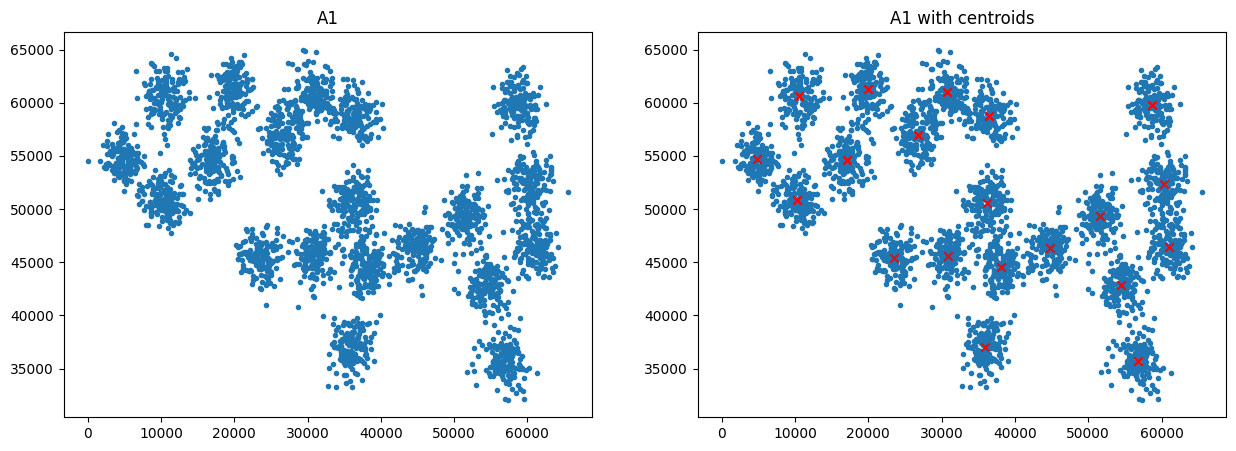

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(a1[:, 0], a1[:, 1], marker='.')
ax[0].set_title('A1')

ax[1].scatter(a1[:, 0], a1[:, 1], marker='.')
ax[1].scatter(a1_centroids[:, 0], a1_centroids[:, 1], c='red', marker='x')
ax[1].set_title('A1 with centroids')

plt.show()

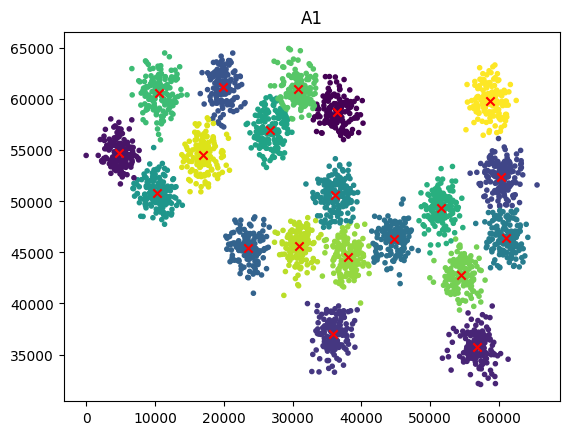

centroid_index: 0


In [8]:
kmeans = KMeans(algorithm='lloyd', init='maximin', seed=42)
kmeans.fit(a1, 20, debug=0)

fig, ax = plt.subplots()
ax.scatter(a1[:, 0], a1[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A1')
plt.show()

print('centroid_index:', centroid_index(a1_centroids, kmeans.centroids))

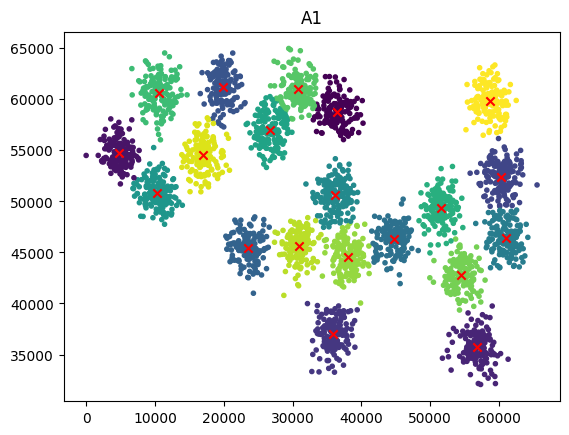

centroid_index: 0


In [9]:
kmeans = KMeans(algorithm='hartigan', init='maximin', seed=42)
kmeans.fit(a1, 20, debug=0)

fig, ax = plt.subplots()
ax.scatter(a1[:, 0], a1[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A1')
plt.show()

print('centroid_index:', centroid_index(a1_centroids, kmeans.centroids))

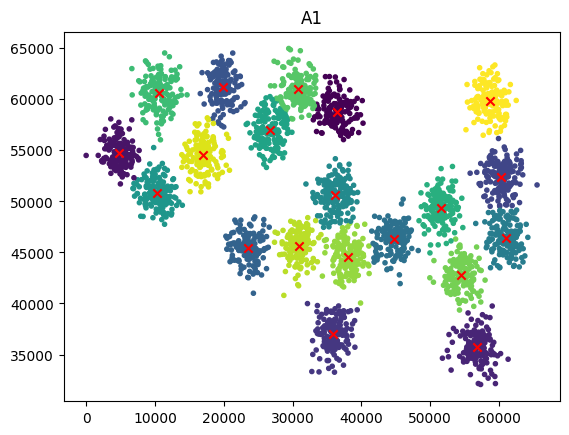

centroid_index: 0


In [10]:
kmeans = KMeans(algorithm='safe-hartigan', init='maximin', seed=42)
kmeans.fit(a1, 20, debug=0)

fig, ax = plt.subplots()
ax.scatter(a1[:, 0], a1[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A1')
plt.show()

print('centroid_index:', centroid_index(a1_centroids, kmeans.centroids))

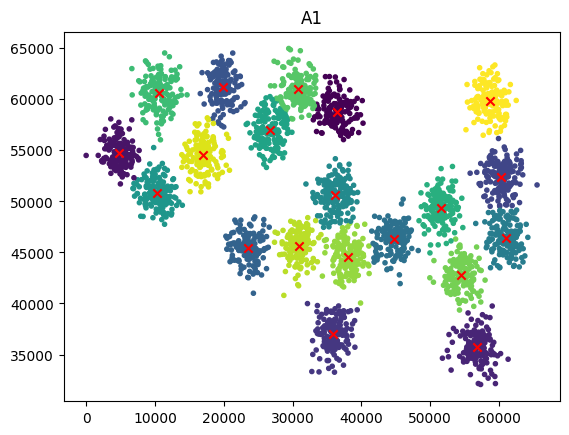

centroid_index: 0


In [11]:
kmeans = KMeans(algorithm='extended-hartigan', init='maximin', seed=42)
kmeans.fit(a1, 20, debug=0)

fig, ax = plt.subplots()
ax.scatter(a1[:, 0], a1[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A1')
plt.show()

print('centroid_index:', centroid_index(a1_centroids, kmeans.centroids))

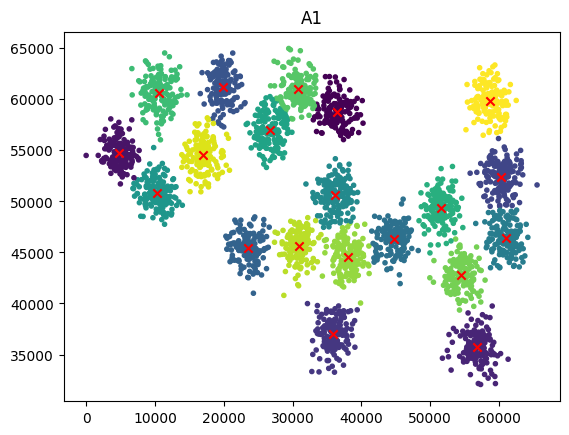

centroid_index: 0


In [12]:
kmeans = KMeans(algorithm='binary-hartigan', init='maximin', seed=42)
kmeans.fit(a1, 20, debug=0)

fig, ax = plt.subplots()
ax.scatter(a1[:, 0], a1[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A1')
plt.show()

print('centroid_index:', centroid_index(a1_centroids, kmeans.centroids))

#### Tests

In [29]:
n_tests = 50
n_iterations = 19

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/A-Sets/a1.txt', init, algo, n_tests, true_centroids=a1_centroids, sep='   ')

Running 950 tests...
Iteration 1/19. Current tests: 0
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done

extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done

mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 2/19. Current tests: 50
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan wit

In [32]:
view_tests(['maximin', 'k-means++', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/A-Sets/a1.txt')

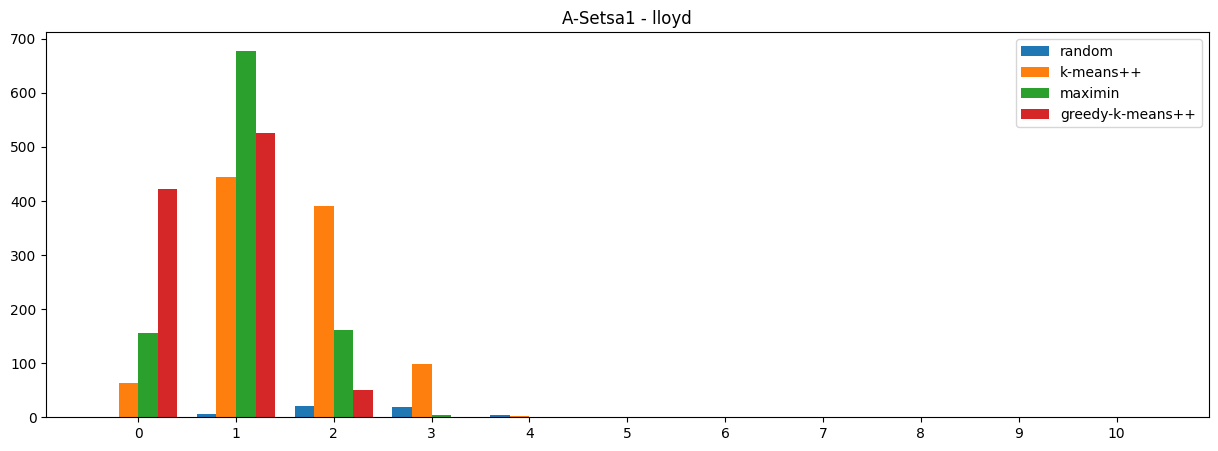

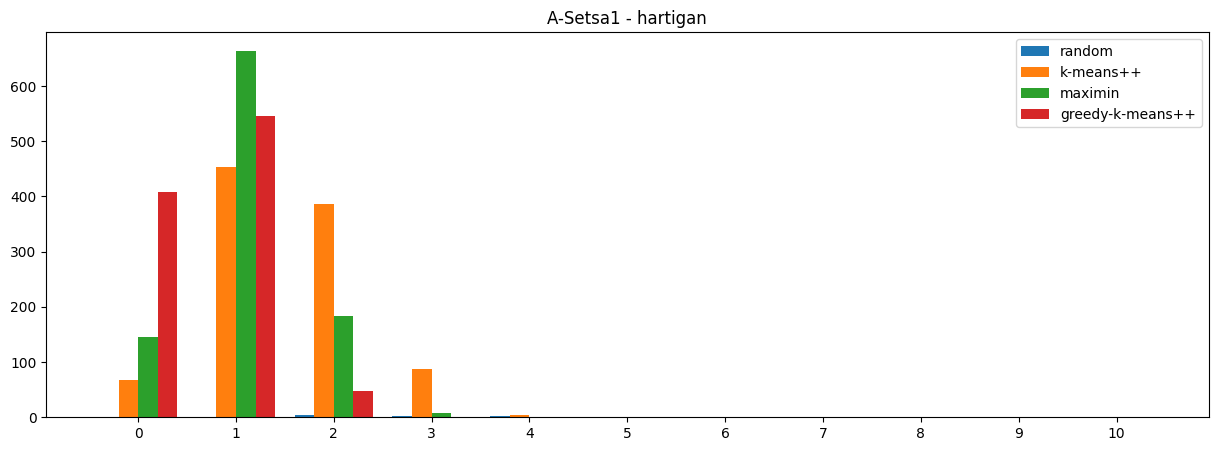

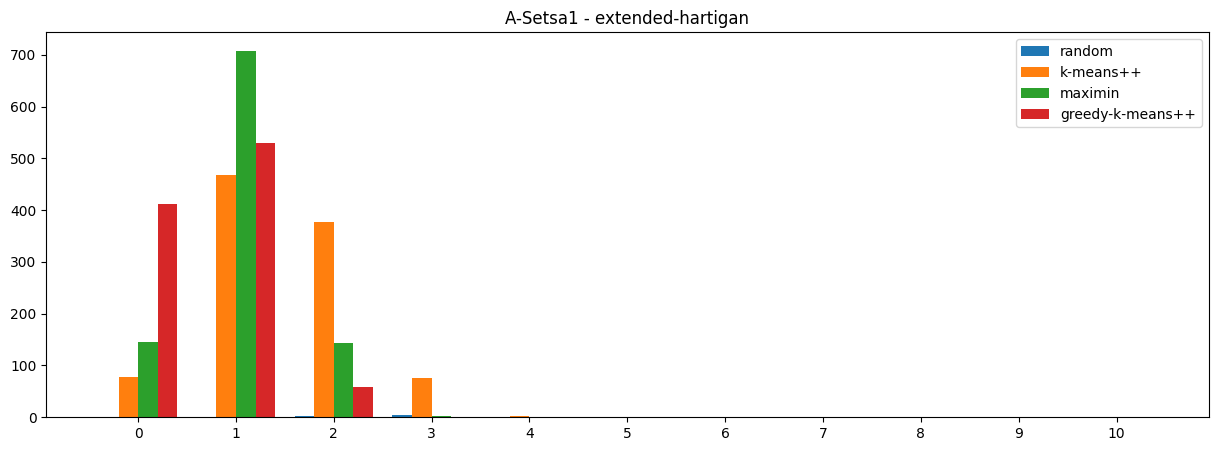

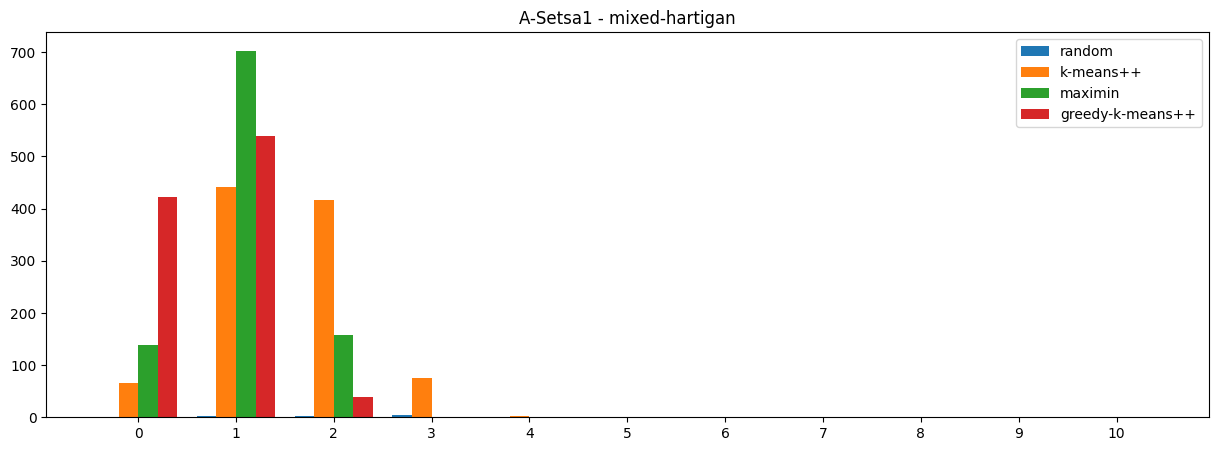

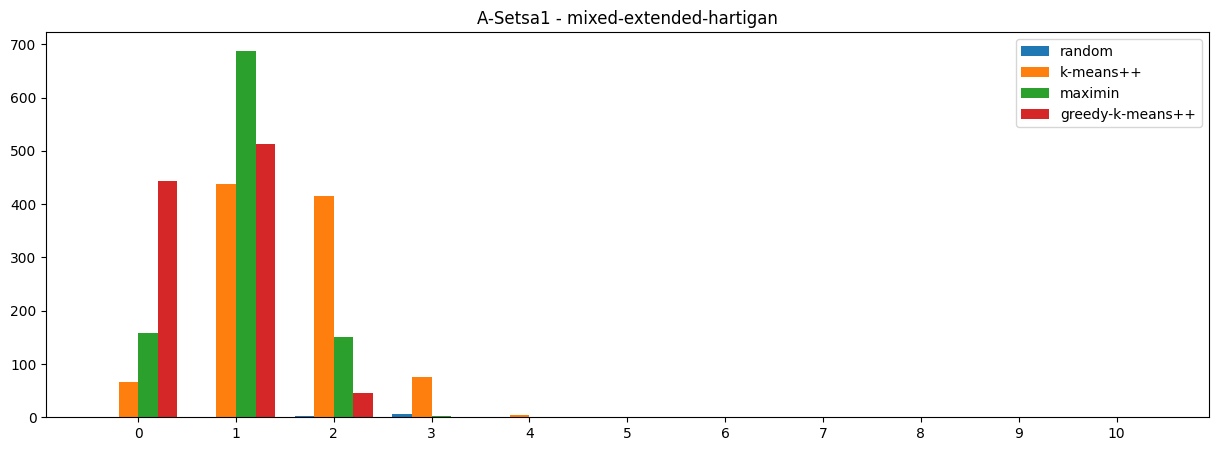

In [33]:
centroid_id_histogram(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/A-Sets/a1.txt')

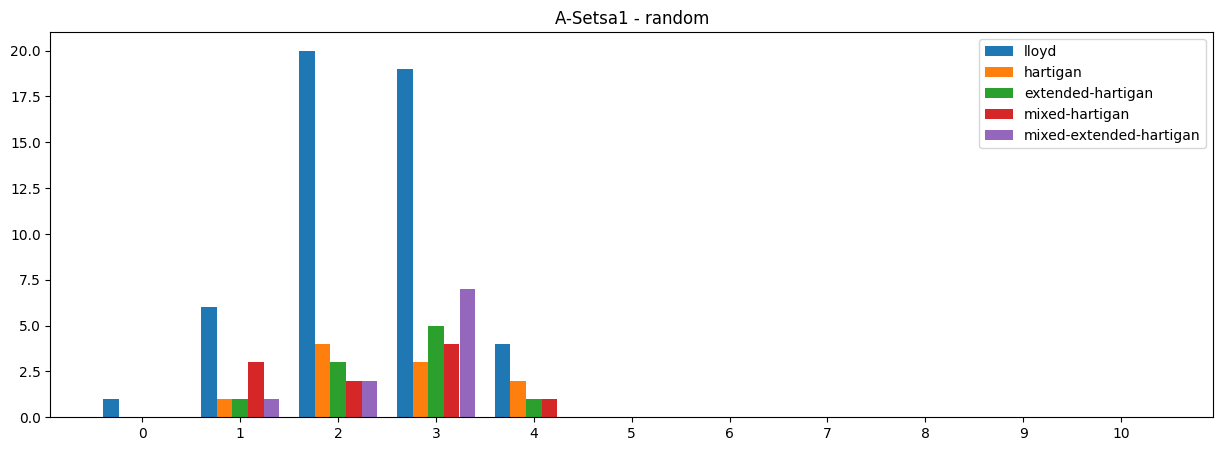

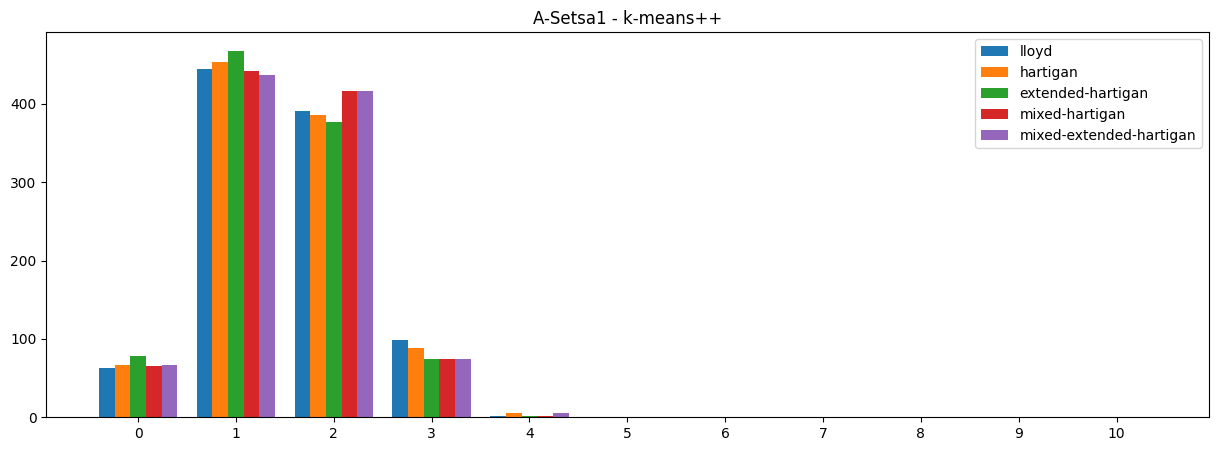

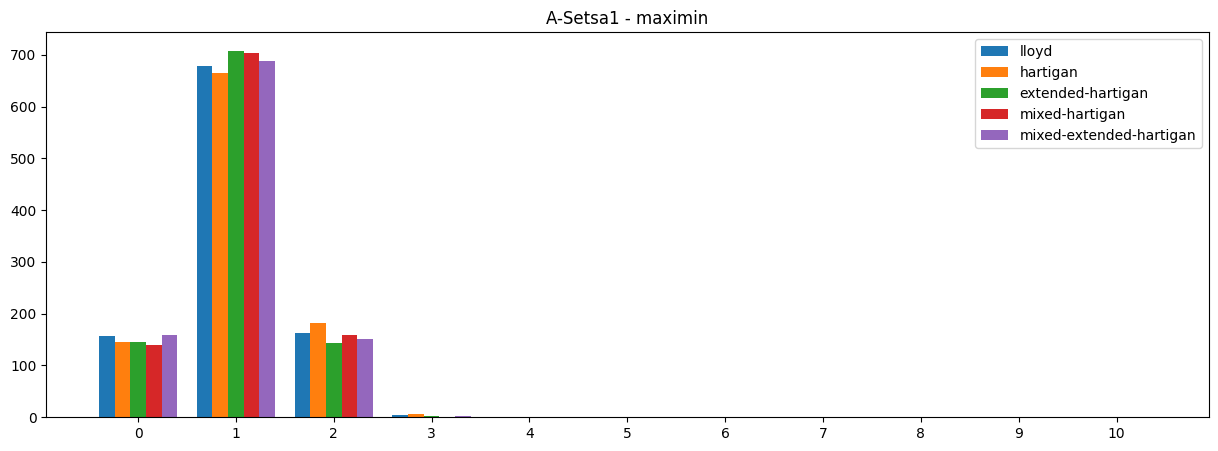

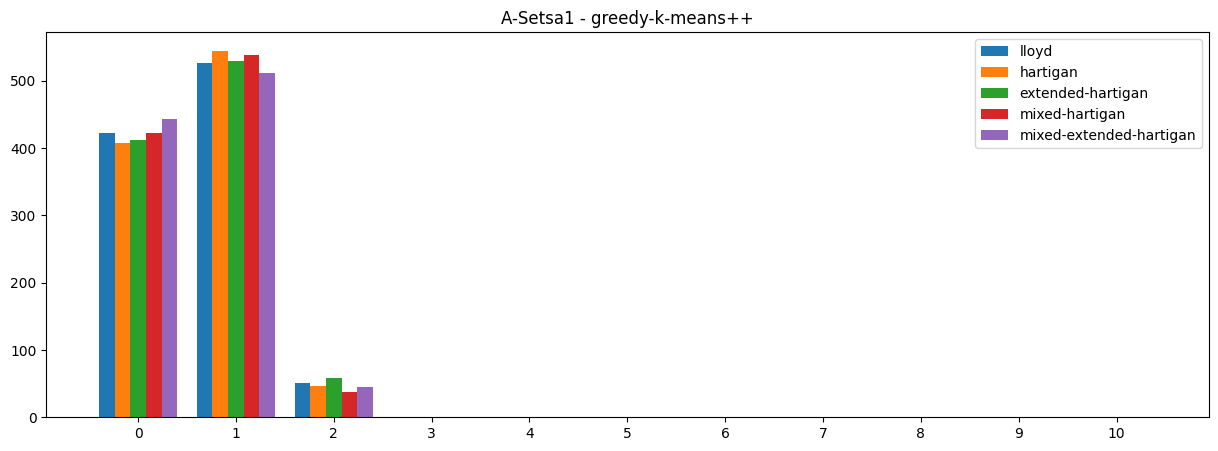

In [34]:
centroid_id_histogram(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/A-Sets/a1.txt', by='init')

### A2

In [27]:
a2 = pd.read_table('data/A-Sets/a2.txt', header=None, sep='   ', engine='python').to_numpy()
a2_centroids = pd.read_table('data/A-Sets/truth/a2-ga-cb.txt', header=None, sep='   ', engine='python').to_numpy()
print('a2:\n', a2)
print('\nshape:', a2.shape)

a2:
 [[53920 42968]
 [52019 42206]
 [52570 42476]
 ...
 [23645 27378]
 [24862 29010]
 [29049 28114]]

shape: (5250, 2)


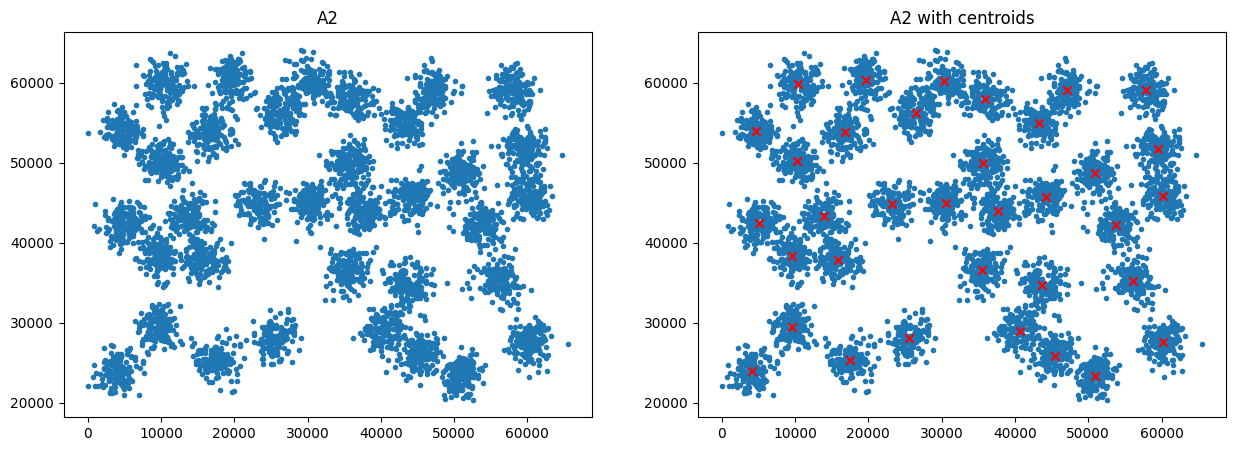

In [28]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(a2[:, 0], a2[:, 1], marker='.')
ax[0].set_title('A2')

ax[1].scatter(a2[:, 0], a2[:, 1], marker='.')
ax[1].scatter(a2_centroids[:, 0], a2_centroids[:, 1], c='red', marker='x')
ax[1].set_title('A2 with centroids')

plt.show()

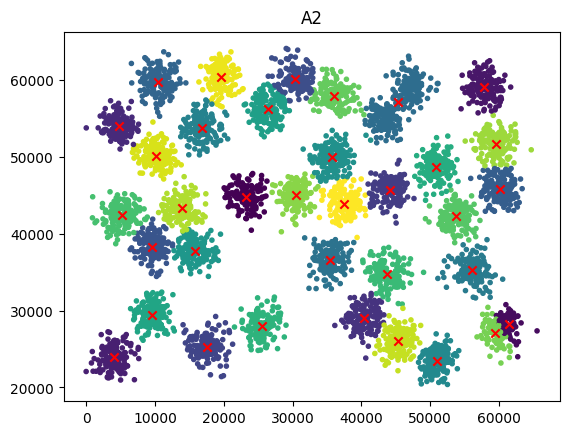

centroid_index: 1


In [21]:
kmeans = KMeans(algorithm='lloyd', init='maximin', seed=12)
kmeans.fit(a2, 35, debug=0)

fig, ax = plt.subplots()
ax.scatter(a2[:, 0], a2[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A2')
plt.show()

print('centroid_index:', centroid_index(a2_centroids, kmeans.centroids))

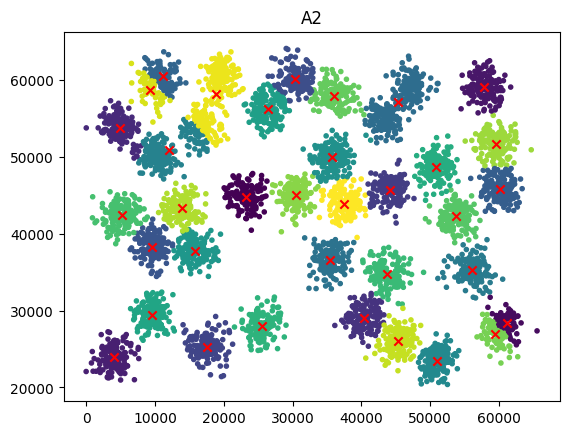

centroid_index: 2


In [34]:
kmeans = KMeans(algorithm='hartigan', init='maximin', seed=12)
kmeans.fit(a2, 35, debug=0)

fig, ax = plt.subplots()
ax.scatter(a2[:, 0], a2[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A2')
plt.show()

print('centroid_index:', centroid_index(a2_centroids, kmeans.centroids))

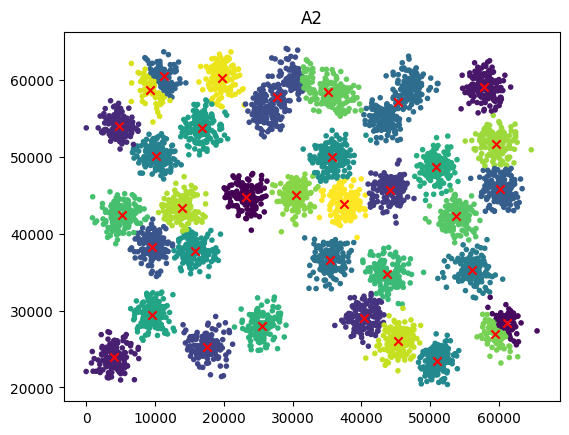

centroid_index: 2


In [36]:
kmeans = KMeans(algorithm='safe-hartigan', init='maximin', seed=12)
kmeans.fit(a2, 35, debug=0)

fig, ax = plt.subplots()
ax.scatter(a2[:, 0], a2[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A2')
plt.show()

print('centroid_index:', centroid_index(a2_centroids, kmeans.centroids))

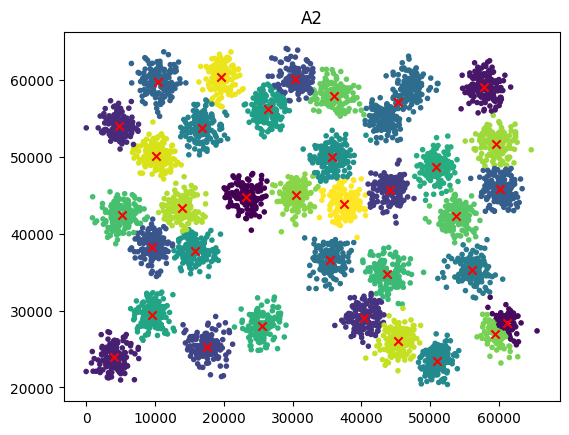

centroid_index: 1


In [37]:
kmeans = KMeans(algorithm='extended-hartigan', init='maximin', seed=12)
kmeans.fit(a2, 35, debug=0)

fig, ax = plt.subplots()
ax.scatter(a2[:, 0], a2[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A2')
plt.show()

print('centroid_index:', centroid_index(a2_centroids, kmeans.centroids))

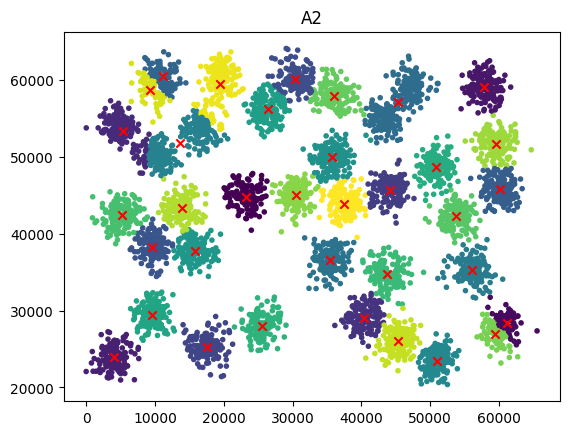

centroid_index: 2


In [39]:
kmeans = KMeans(algorithm='binary-hartigan', init='maximin', seed=12)
kmeans.fit(a2, 35, debug=0)

fig, ax = plt.subplots()
ax.scatter(a2[:, 0], a2[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A2')
plt.show()

print('centroid_index:', centroid_index(a2_centroids, kmeans.centroids))

#### Tests

In [ ]:
n_tests = 50
n_iterations = 20

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/A-Sets/a2.txt', init, algo, n_tests, true_centroids=a2_centroids, sep='   ')

Running 1000 tests...
Iteration 1/20. Current tests: 0


C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 2/20. Current tests: 50
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done

extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done

mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 3/

In [36]:
view_tests(['random', 'maximin', 'k-means++', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/A-Sets/a2.txt')

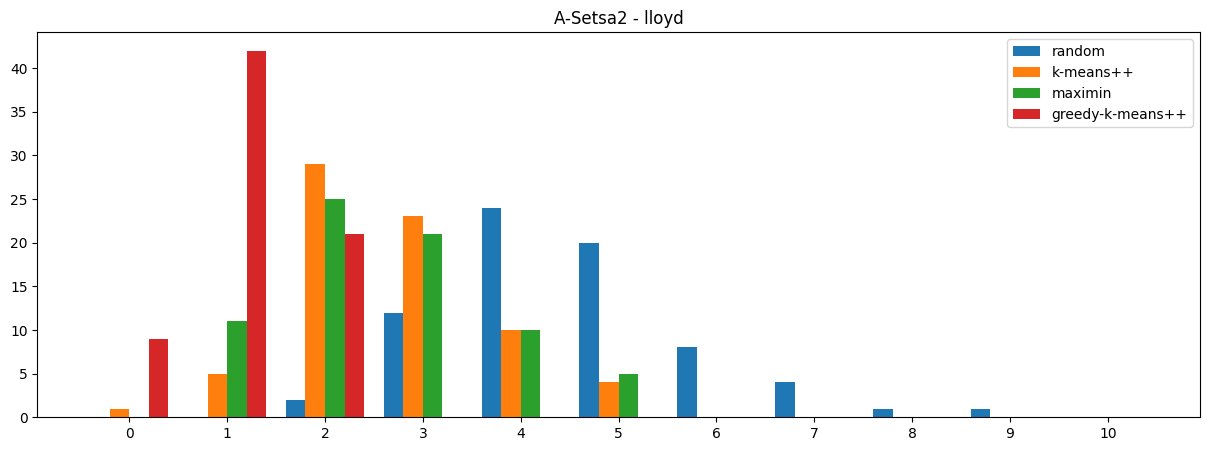

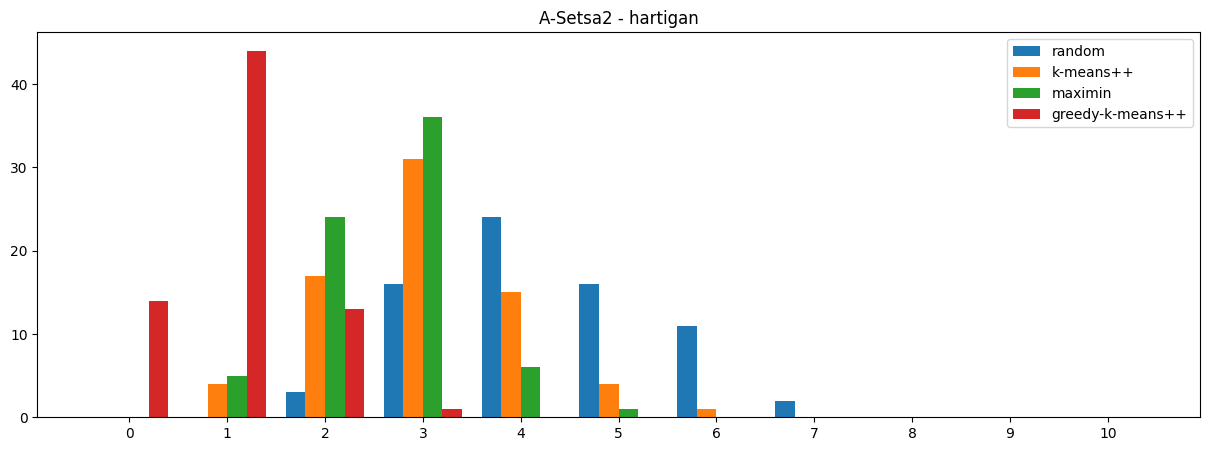

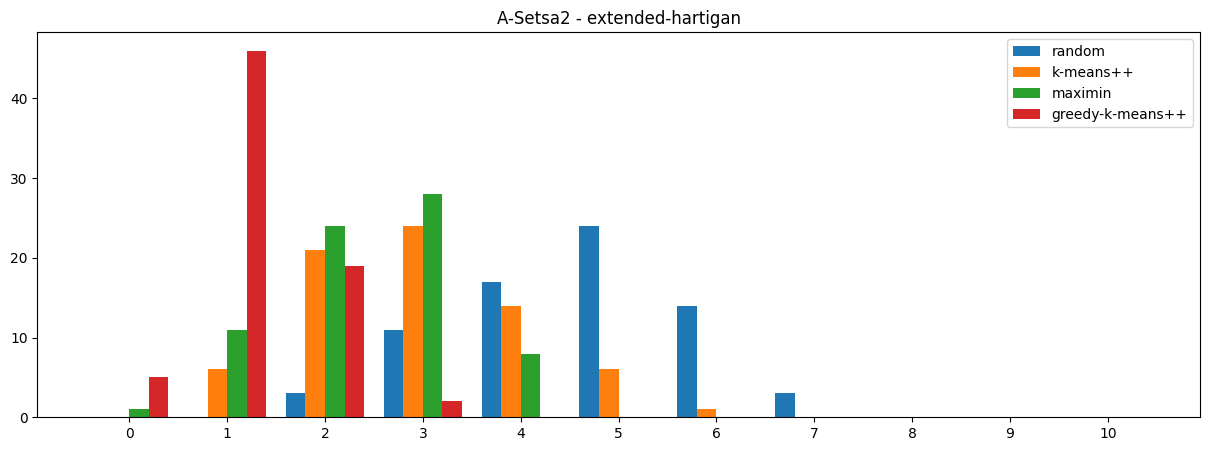

In [84]:
centroid_id_histogram(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan'], 'data/A-Sets/a2.txt')

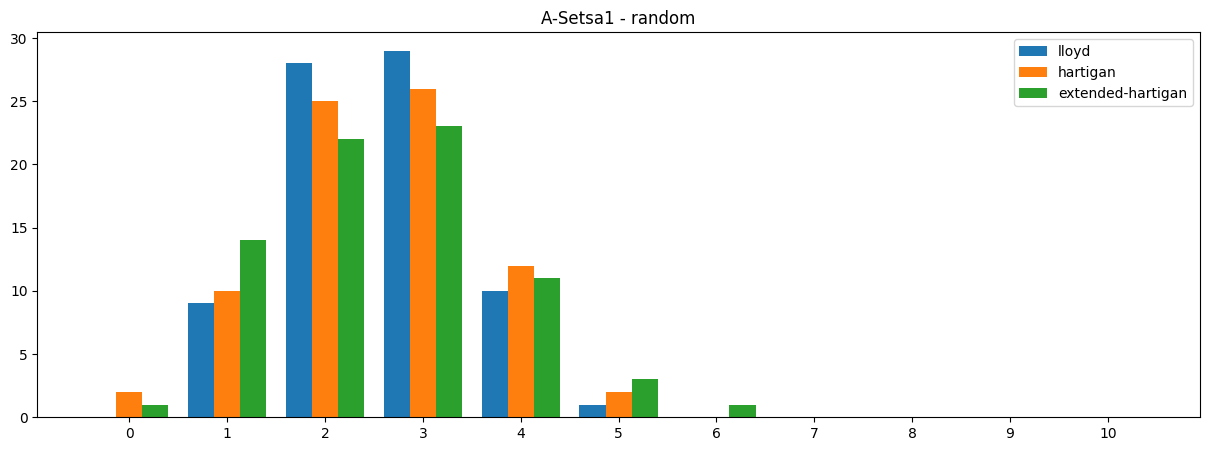

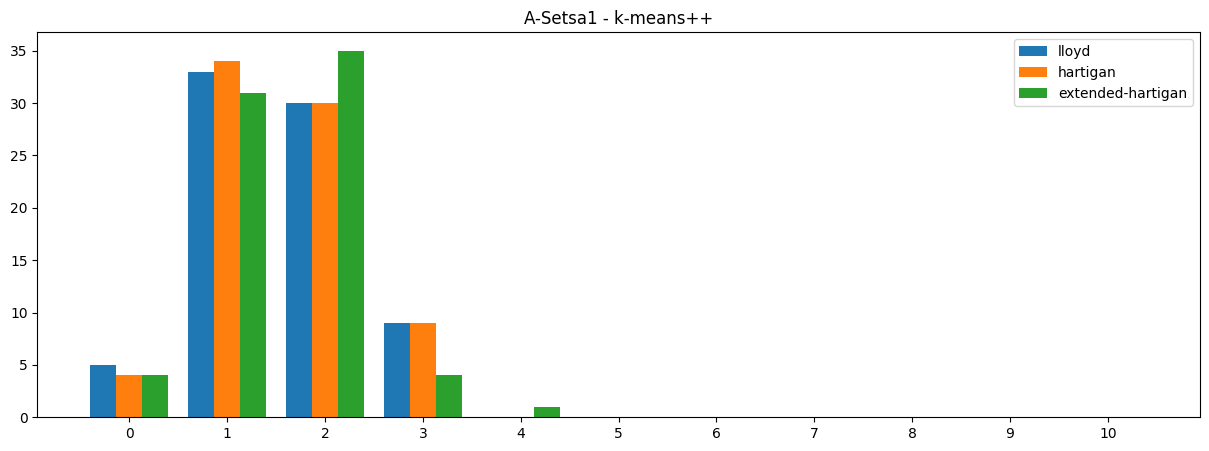

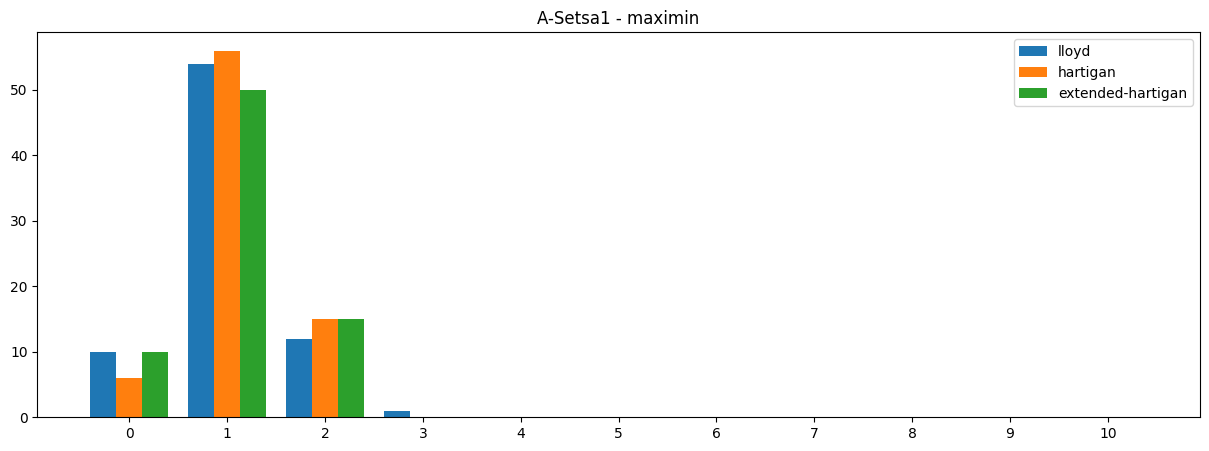

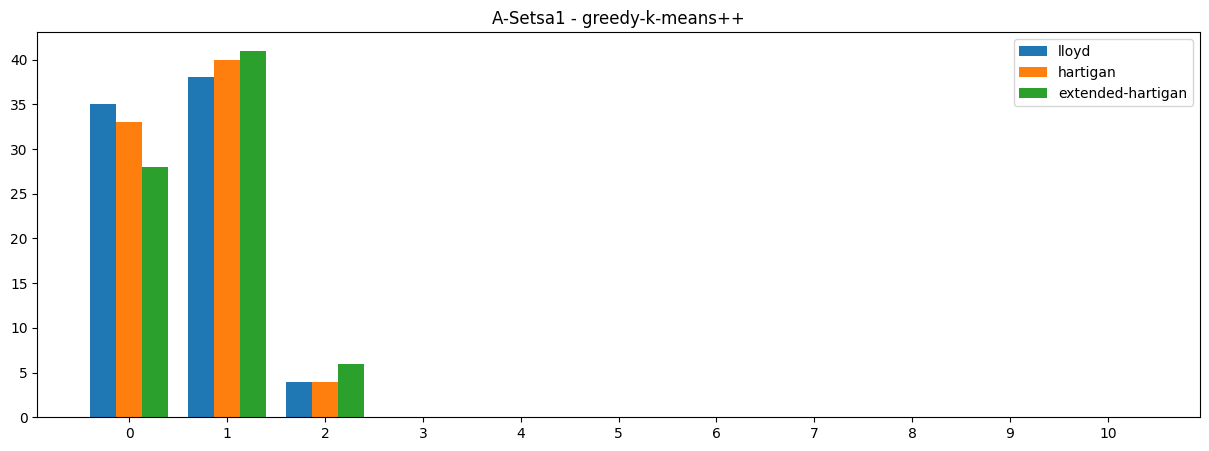

In [83]:
centroid_id_histogram(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan'], 'data/A-Sets/a1.txt', by='init')

### A3

In [16]:
a3 = pd.read_table('data/A-Sets/a3.txt', header=None, sep='   ', engine='python').to_numpy()
a3_centroids = pd.read_table('data/A-Sets/truth/a3-ga-cb.txt', header=None, sep='   ', engine='python').to_numpy()
print('a3:\n', a3)
print('\nshape:', a3.shape)

a3:
 [[53920 42968]
 [52019 42206]
 [52570 42476]
 ...
 [41140 18409]
 [37752 19891]
 [40164 17389]]

shape: (7500, 2)


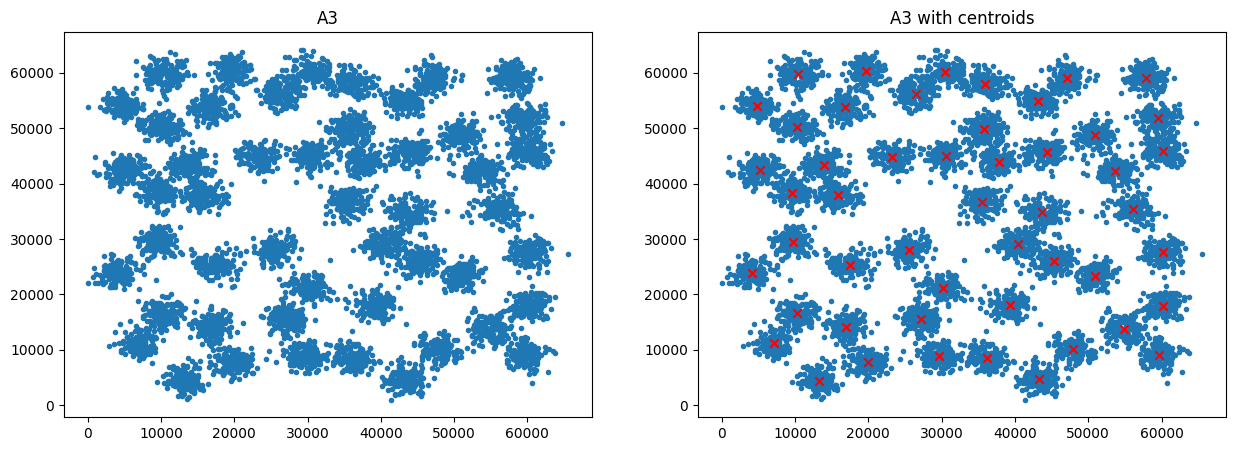

In [17]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(a3[:, 0], a3[:, 1], marker='.')
ax[0].set_title('A3')

ax[1].scatter(a3[:, 0], a3[:, 1], marker='.')
ax[1].scatter(a3_centroids[:, 0], a3_centroids[:, 1], c='red', marker='x')
ax[1].set_title('A3 with centroids')

plt.show()

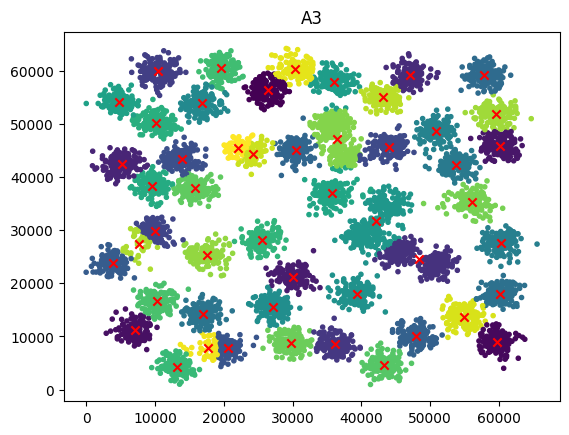

centroid_index: 3


In [59]:
kmeans = KMeans(algorithm='lloyd', init='maximin', seed=12)
kmeans.fit(a3, 50, debug=0)

fig, ax = plt.subplots()
ax.scatter(a3[:, 0], a3[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A3')
plt.show()

print('centroid_index:', centroid_index(a3_centroids, kmeans.centroids))

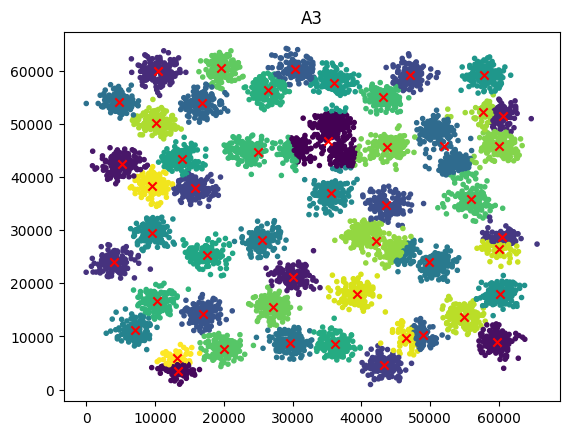

centroid_index: 4


In [45]:
kmeans = KMeans(algorithm='hartigan', init='maximin', seed=42)
kmeans.fit(a3, 50, debug=0)

fig, ax = plt.subplots()
ax.scatter(a3[:, 0], a3[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A3')
plt.show()

print('centroid_index:', centroid_index(a3_centroids, kmeans.centroids))

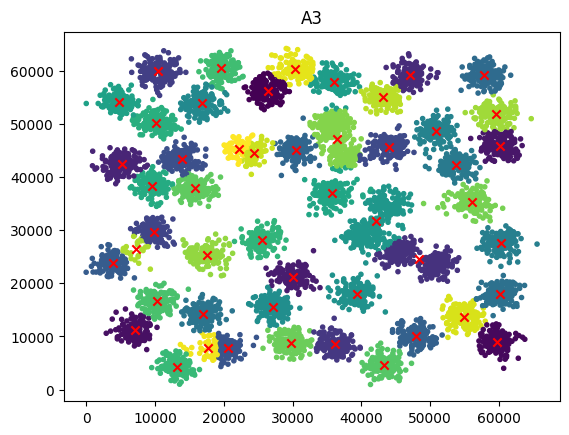

centroid_index: 3


In [58]:
kmeans = KMeans(algorithm='extended-hartigan', init='maximin', seed=12)
kmeans.fit(a3, 50, debug=0)

fig, ax = plt.subplots()
ax.scatter(a3[:, 0], a3[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A3')
plt.show()

print('centroid_index:', centroid_index(a3_centroids, kmeans.centroids))

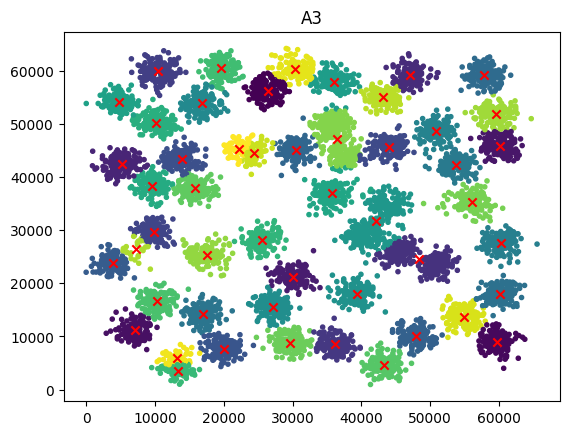

centroid_index: 3


In [ ]:
kmeans = KMeans(algorithm='binary-hartigan', init='maximin', seed=42)
kmeans.fit(a3, 50, debug=0)

fig, ax = plt.subplots()
ax.scatter(a3[:, 0], a3[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A3')
plt.show()

print('centroid_index:', centroid_index(a3_centroids, kmeans.centroids))

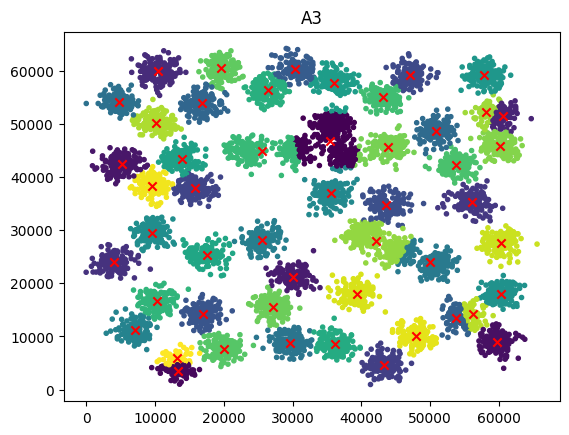

centroid_index: 3


In [50]:
kmeans = KMeans(algorithm='safe-hartigan', init='maximin', seed=42)
kmeans.fit(a3, 50, debug=0)

fig, ax = plt.subplots()
ax.scatter(a3[:, 0], a3[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('A3')
plt.show()

print('centroid_index:', centroid_index(a3_centroids, kmeans.centroids))

#### Tests

In [37]:
n_tests = 50
n_iterations = 20

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/A-Sets/a3.txt', init, algo, n_tests, true_centroids=a1_centroids, sep='   ')

Running 1000 tests...
Iteration 1/20. Current tests: 0


C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11336\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 2/20. Current tests: 50
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done

extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done

mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 3/

In [42]:
view_tests(['random', 'maximin', 'k-means++', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/A-Sets/a3.txt')

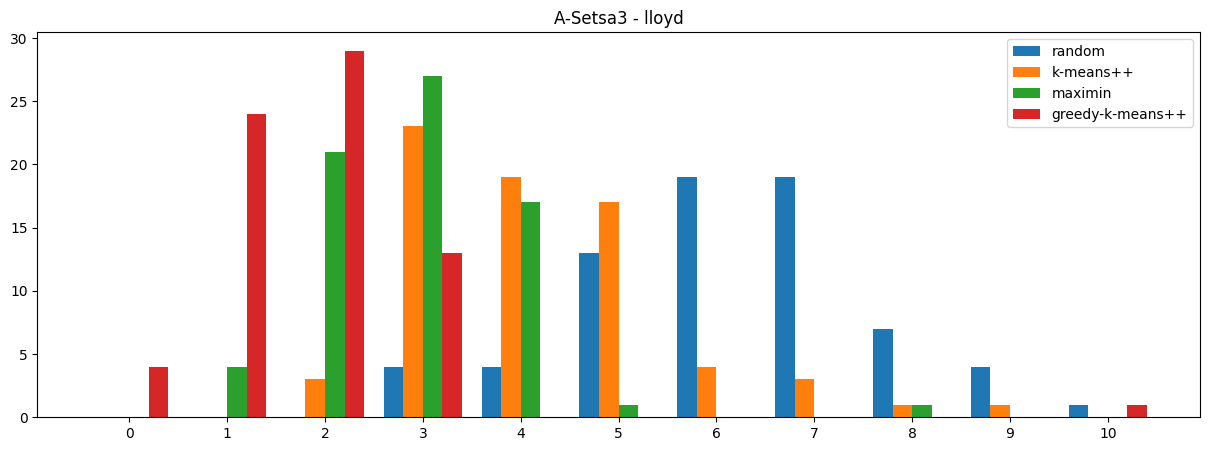

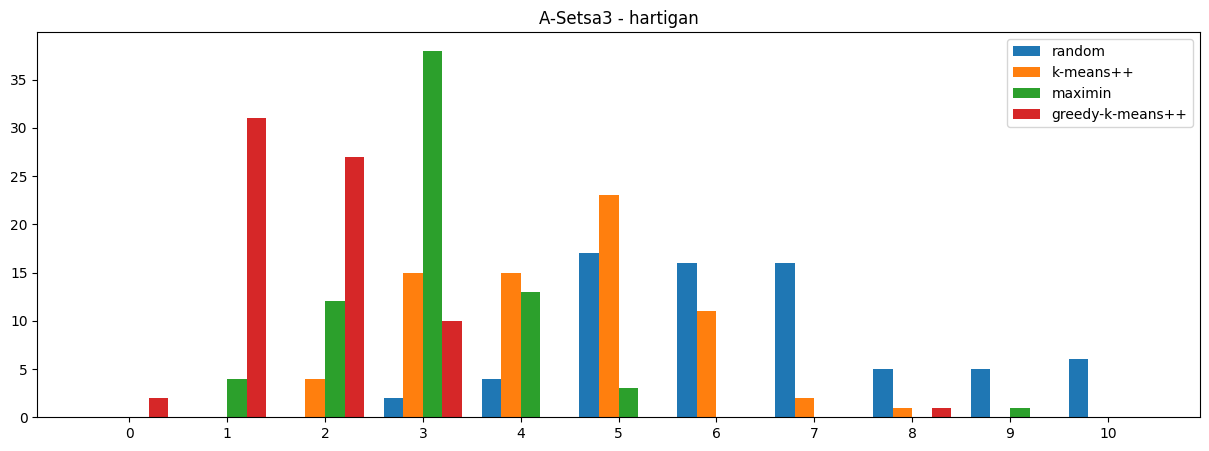

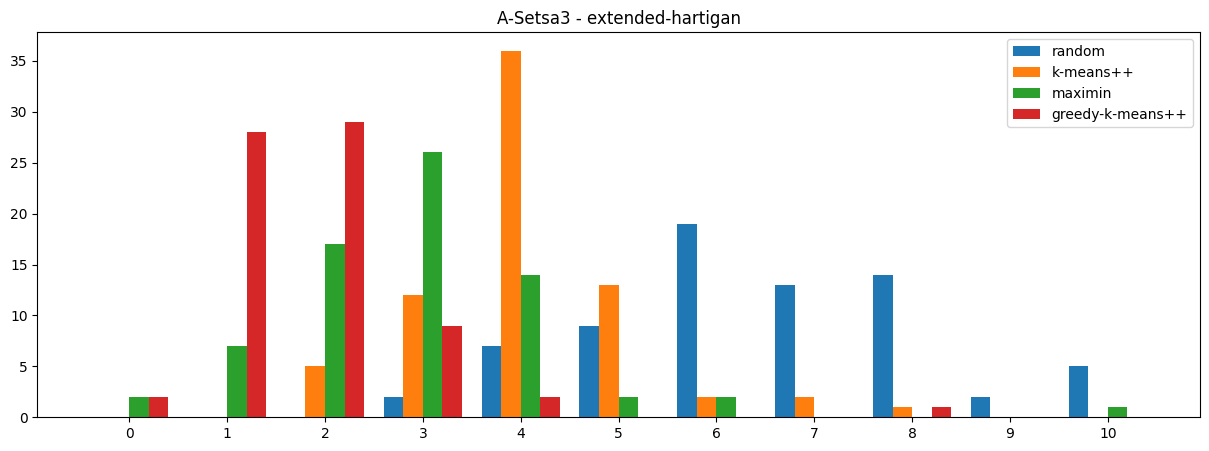

In [85]:
centroid_id_histogram(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan'], 'data/A-Sets/a3.txt')

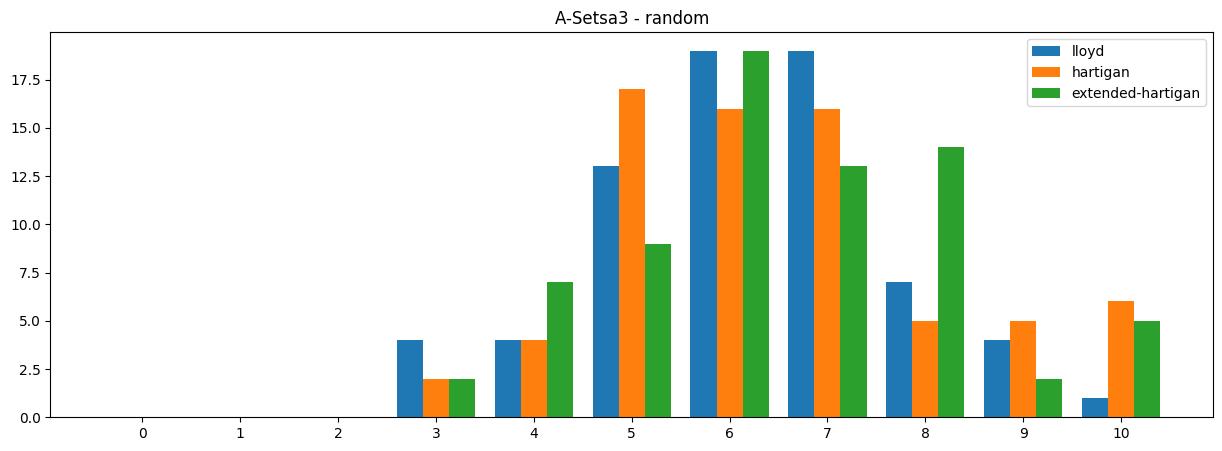

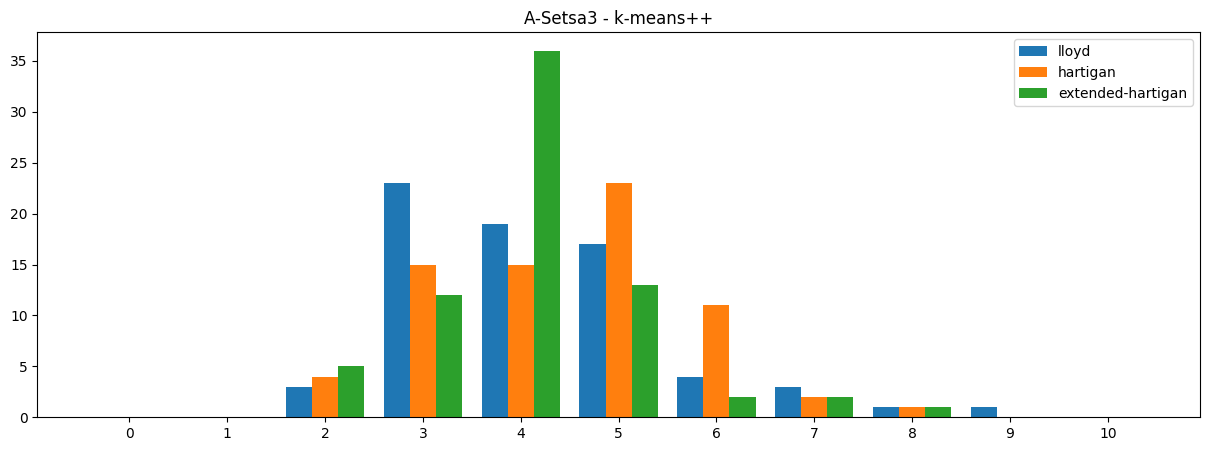

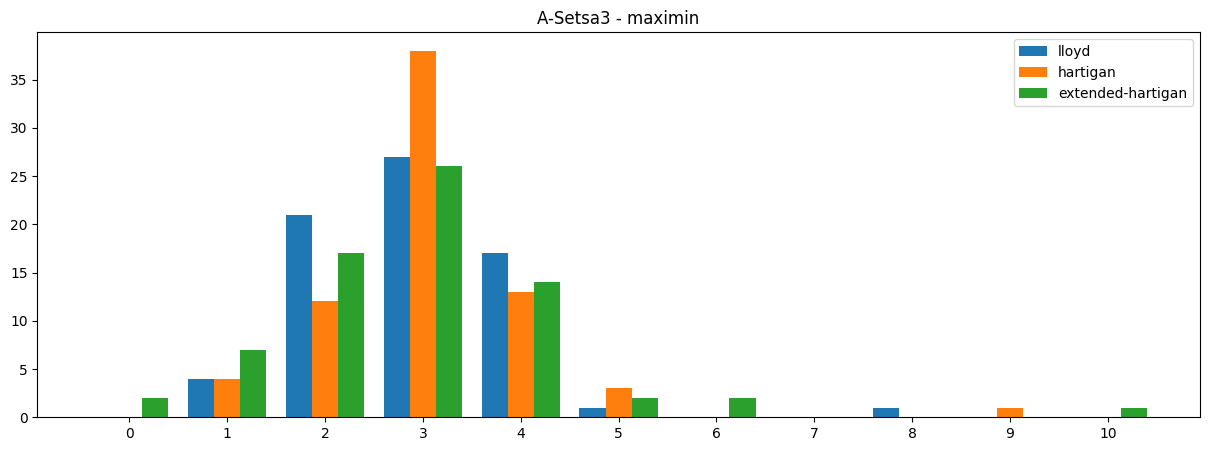

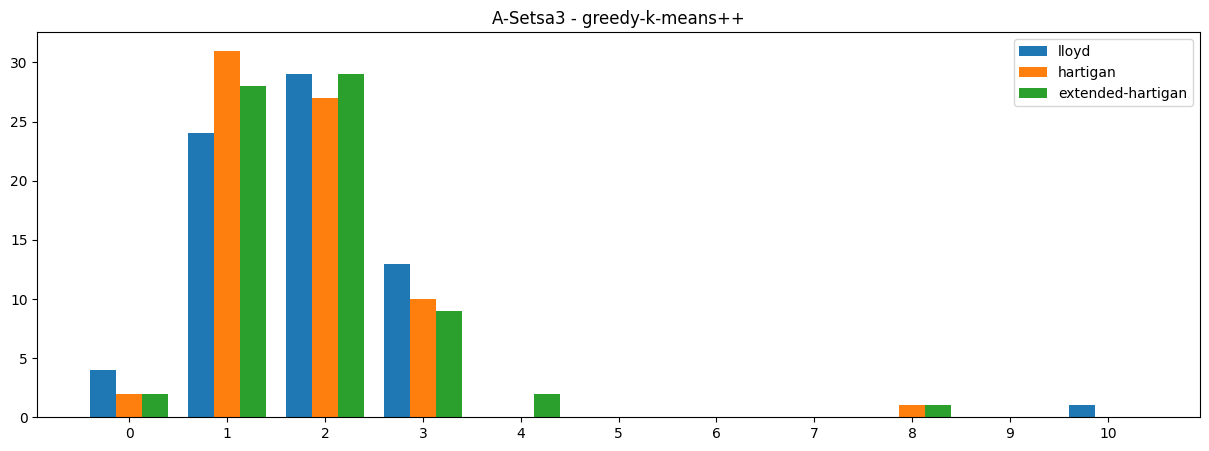

In [86]:
centroid_id_histogram(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan'], 'data/A-Sets/a3.txt', by='init')

## BIRCH

### BIRCH1

In [88]:
birch1 = pd.read_table('data/Birch/birch1.txt', header=None, sep='         |        |       |      |     |    |   ', engine='python').to_numpy()
birch1_centroids = pd.read_table('data/Birch/truth/b1-gt.txt', header=None, sep=' ', engine='python').to_numpy()
print('birch1:\n', birch1)
print('\nshape:', birch1.shape)

birch1:
 [[ 58164 813431]
 [ 58160  84514]
 [ 58148 550001]
 ...
 [288571 806890]
 [288575 318803]
 [288587 866362]]

shape: (100000, 2)


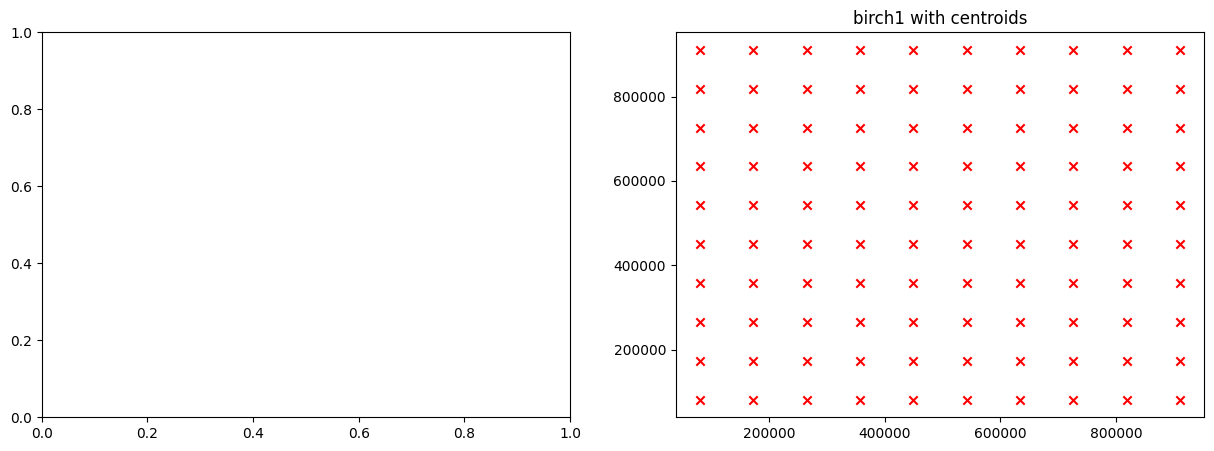

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
# ax[0].scatter(birch1[:, 0], birch1[:, 1], marker='.')
# ax[0].set_title('birch1')

# ax[1].scatter(birch1[:, 0], birch1[:, 1], marker='.')
ax[1].scatter(birch1_centroids[:, 0], birch1_centroids[:, 1], c='red', marker='x')
ax[1].set_title('birch1 with centroids')

plt.show()

In [47]:
test_all('data/Birch/birch1.txt', birch1_centroids, 1, sep='         |        |       |      |     |    |   ')

KeyboardInterrupt: 

In [90]:
n_tests = 1    # set this to the desired number of tests to run
init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['extended-hartigan', 'binary-hartigan']
test_all('data/Birch/birch1.txt', init, algo, n_tests, true_centroids=birch1_centroids, sep='         |        |       |      |     |    |   ')

KeyboardInterrupt: 

In [93]:
view_tests(['random', 'maximin', 'k-means++', 'greedy-k-means++'], ['lloyd'], 'data/Birch/birch1.txt')

count  min_centroid_index  max_centroid_index  \
Algorithm Initialization                                                    
lloyd     random                1                  11                  11   
          k-means++             2                   4                   7   
          maximin               2                   5                   5   
          greedy-k-means++      2                   4                   4   

                            mean_centroid_index  std_centroid_index  \
Algorithm Initialization                                              
lloyd     random                           11.0                 0.0   
          k-means++                         5.5                 1.5   
          maximin                           5.0                 0.0   
          greedy-k-means++                  4.0                 0.0   

                            mean_time_execution  min_final_cost  \
Algorithm Initialization                                          
lloyd     random                      16.623802    1.213895e+14   
          k-means++                   16.011341    1.027314e+14   
          maximin                     19.640332    1.049250e+14   
          greedy-k-means++            47.474281    1.028192e+14   

                            mean_final_cost  max_final_cost  std_final_cost  \
Algorithm Initialization                                                      
lloyd     random               1.213895e+14    1.213895e+14    0.000000e+00   
          k-means++            1.066652e+14    1.105990e+14    3.933809e+12   
          maximin              1.050895e+14    1.052539e+14    1.644203e+11   
          greedy-k-means++     1.028307e+14    1.028422e+14    1.151553e+10   

                            mean_iterations  mean_norm_calculations  
Algorithm Initialization                                             
lloyd     random                      230.0                0.012310  
          k-means++                    76.0               41.505360  
          maximin                     107.0               41.005675  
          greedy-k-means++             66.0              327.948395

## BRIDGE

In [191]:
bridge = pd.read_table('data/bridge.txt', header=None, sep='     |    |   |  | ', engine='python').to_numpy()
print('bridge:\n', bridge)
print('\nbridge:', bridge.shape)

bridge:
 [[  6   8   6 ...   0   0   0]
 [  7   4   3 ...   0   0   0]
 [  8   8   8 ...  99 104  79]
 ...
 [251 247 243 ... 127 141 153]
 [252 250 249 ...  92  94  99]
 [253 224 209 ... 246 233 227]]

bridge: (4096, 16)


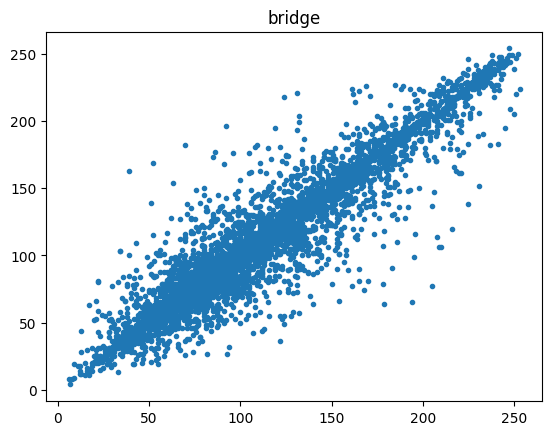

In [98]:
# make a plot
fig, ax = plt.subplots()
ax.scatter(bridge[:, 0], bridge[:, 1], marker='.')
ax.set_title('bridge')

plt.show()

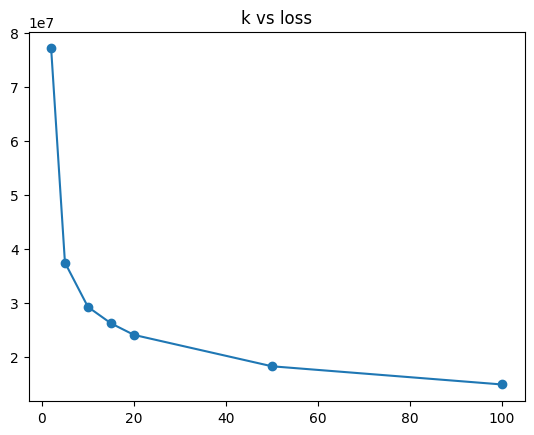

In [101]:
# try clustering with different k's and plot k vs loss
data = pd.read_table('data/bridge.txt', header=None, sep='     |    |   |  | ', engine='python').to_numpy(dtype=int)

cost = []

for k in [2,5,10,15,20,50,100]:
    kmeans = KMeans(algorithm='extended-hartigan', init='greedy-k-means++')
    kmeans.fit(data, k, debug=0)
    cost.append(kmeans._tot_cluster_cost(kmeans.centroids, kmeans.y_pred))

fig, ax = plt.subplots()
ax.plot([2,5,10,15,20,50,100], cost, marker='o')
plt.title('k vs loss')
plt.show()

#### $k=5$

In [6]:
n_tests = 50
n_iterations = 5

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/bridge5.txt', init, algo, n_tests, k=5, sep='     |    |   |  | ')

Running 250 tests...
Iteration 1/5. Current tests: 0
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done

extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done

mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 2/5. Current tests: 50
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with 

In [7]:
n_tests = 50
n_iterations = 8

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/bridge5.txt', init, algo, n_tests, k=5, sep='     |    |   |  | ')

Running 400 tests...
Iteration 1/8. Current tests: 0
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done

extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done

mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 2/8. Current tests: 50
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done

hartigan with 

In [6]:
view_tests(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/bridge5.txt')

#### $k=10$

In [10]:
n_tests = 50
n_iterations = 20

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/bridge.txt', init, algo, n_tests, k=10, sep='     |    |   |  | ')

Running 50 tests...
Iteration 1/1. Current tests: 0
mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done



In [11]:
view_tests(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/bridge.txt')

#### $k=100$

In [12]:
n_tests = 50
n_iterations = 1

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/bridge100.txt', init, algo, n_tests, k=100, sep='     |    |   |  | ')

Running 50 tests...
Iteration 1/1. Current tests: 0
hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done

extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done

mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done



In [13]:
view_tests(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/bridge100.txt')

## D31

In [49]:
d31 = pd.read_table('data/D31/D31.txt', header=None, engine='python').to_numpy()
print('D31:\n', d31)
print('D31.shape:', d31.shape)

D31:
 [[25.0514  5.7475  1.    ]
 [26.6614  7.3414  1.    ]
 [25.2653  6.2466  1.    ]
 ...
 [ 5.276  17.2475 31.    ]
 [ 6.4444 16.2033 31.    ]
 [ 7.162  18.1836 31.    ]]
D31.shape: (3100, 3)


X:
 [[25.0514  5.7475]
 [26.6614  7.3414]
 [25.2653  6.2466]
 ...
 [ 5.276  17.2475]
 [ 6.4444 16.2033]
 [ 7.162  18.1836]]

y:
 [ 1  1  1 ... 31 31 31]


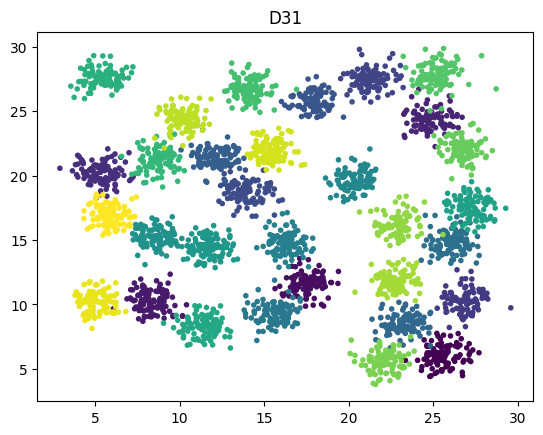

In [39]:
# separate two dimensions and actual classes
X = bridge[:, :-1]
y = bridge[:, -1].astype(int)
print('X:\n', X)
print('\ny:\n', y)

# save X and y into a file
np.savetxt('data/D31/data.txt', X, delimiter=',', fmt='%.4f')
np.savetxt('data/D31/labels.txt', y, delimiter=',', fmt='%d')

# make a plot
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], marker='.', c=y)
ax.set_title('D31')
plt.show()

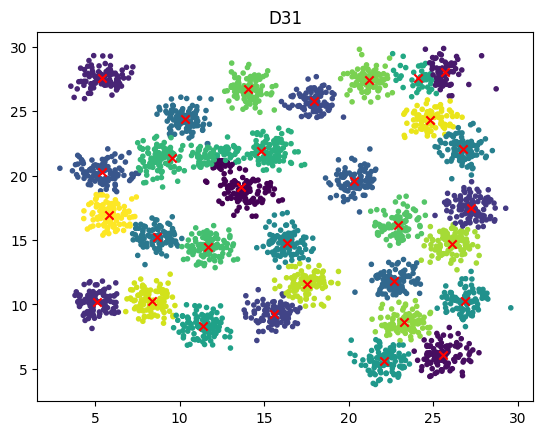

accuracy: 0.9329032258064516


In [40]:
kmeans = KMeans(algorithm='extended-hartigan', init='maximin', seed=42)
kmeans.fit(X, 31, debug=0)
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], c=kmeans.y_pred, marker='.')
ax.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x')
plt.title('D31')
plt.show()

print('accuracy:', accuracy(y, kmeans.y_pred))

In [ ]:
n_tests = 50
n_iterations = 20

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/D31/data.txt', init, algo, n_tests, k=31, true_centroids=None, sep=',')

Running 10 tests...
Iteration 1/1. Current tests: 0


C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done



In [43]:
view_tests(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/D31/data.txt')

## OVERLAP

In [65]:
overlap = pd.read_table('data/overlap.txt', header=None, sep=' ', engine='python').to_numpy()
print('overlap:\n', overlap)
print('overlap.shape:', overlap.shape)

overlap:
 [[1965 2300]
 [1969 2274]
 [1876 2024]
 ...
 [1848 2645]
 [2229 2524]
 [2232 2127]]
overlap.shape: (1000, 2)


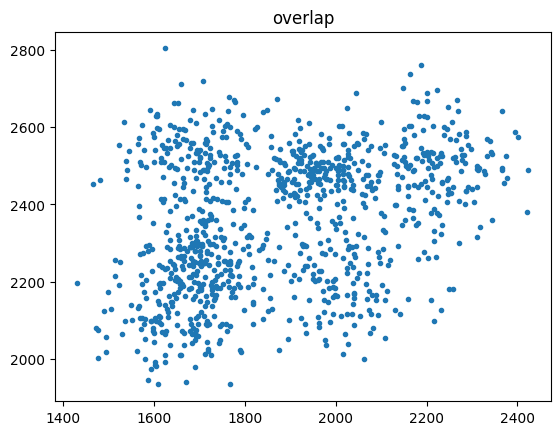

In [66]:
# make a plot
fig, ax = plt.subplots()
ax.scatter(overlap[:, 0], overlap[:, 1], marker='.')
ax.set_title('overlap')

plt.show()

In [75]:
n_tests = 50
n_iterations = 20

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/overlap.txt', init, algo, n_tests, k=6, true_centroids=None, sep=' ')

Running 10 tests...
Iteration 1/1. Current tests: 0
lloyd with maximin initialization done
lloyd with k-means++ initialization done
lloyd with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)
C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


hartigan with maximin initialization done
hartigan with k-means++ initialization done
hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


extended-hartigan with maximin initialization done
extended-hartigan with k-means++ initialization done
extended-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-hartigan with maximin initialization done
mixed-hartigan with k-means++ initialization done
mixed-hartigan with greedy-k-means++ initialization done



C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with k-means++ initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done



In [76]:
view_tests(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/overlap.txt')

## HOUSE

In [77]:
house = pd.read_table('data/housec5.txt', header=None, sep='     |    |   |  | ', engine='python').to_numpy()
print('house:\n', house)
print('house.shape:', house.shape)

house:
 [[ 24   0  40]
 [ 24   0  48]
 [ 24   8  40]
 ...
 [232 232 224]
 [232 240 216]
 [232 240 224]]
house.shape: (1837, 3)


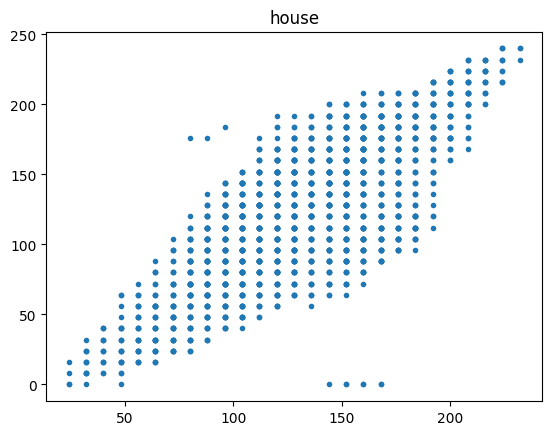

In [78]:
# make a plot
fig, ax = plt.subplots()
ax.scatter(house[:, 0], house[:, 1], marker='.')
ax.set_title('house')

plt.show()

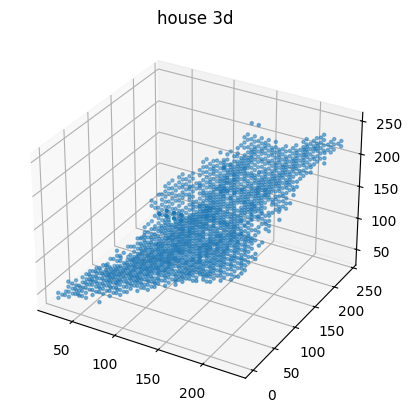

In [79]:
# make a 3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(house[:, 0], house[:, 1], house[:, 2], marker='.')
ax.set_title('house 3d')
plt.show()

k: 2
k: 5
k: 10
k: 15
k: 20
k: 50
k: 100


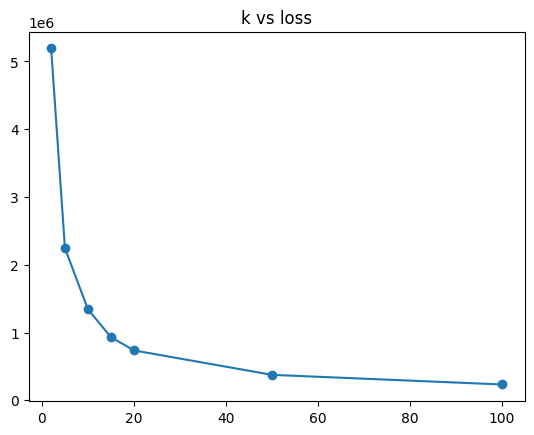

In [81]:
# try clustering with different k's and plot k vs loss
data = pd.read_table('data/housec5.txt', header=None, sep='     |    |   |  | ', engine='python').to_numpy(dtype=int)

cost = []

for k in [2,5,10,15,20,50,100]:
    print('k:', k)
    kmeans = KMeans(algorithm='lloyd', init='greedy-k-means++')
    kmeans.fit(data, k, debug=0)
    cost.append(kmeans._tot_cluster_cost(kmeans.centroids, kmeans.y_pred))

fig, ax = plt.subplots()
ax.plot([2,5,10,15,20,50,100], cost, marker='o')
plt.title('k vs loss')
plt.show()

### $k = 50$

In [10]:
n_tests = 50
n_iterations = 13

init = ['maximin', 'greedy-k-means++']
algo = ['mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/housec5.txt', init, algo, n_tests, k=50, sep='     |    |   |  | ')

Running 650 tests...
Iteration 1/13. Current tests: 0
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 2/13. Current tests: 50
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 3/13. Current tests: 100
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initialization done
mixed-extended-hartigan with greedy-k-means++ initialization done

Iteration 4/13. Current tests: 150
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

mixed-extended-hartigan with maximin initializ

KeyboardInterrupt: 

In [19]:
n_tests = 50
n_iterations = 9

init = ['maximin', 'greedy-k-means++']
algo = ['mixed-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/housec5.txt', init, algo, n_tests, k=50, sep='     |    |   |  | ')

Running 450 tests...
Iteration 1/9. Current tests: 0
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

Iteration 2/9. Current tests: 50
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

Iteration 3/9. Current tests: 100
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

Iteration 4/9. Current tests: 150
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

Iteration 5/9. Current tests: 200
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

Iteration 6/9. Current tests: 250
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

Iteration 7/9. Current tests: 300
mixed-hartigan with maximin initialization done
mixed-hartigan with greedy-k-means++ initialization done

It

In [20]:
view_tests(['random', 'k-means++', 'maximin', 'greedy-k-means++'], ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan'], 'data/housec5.txt')

### $k = 100$

In [ ]:
n_tests = 50
n_iterations = 20

init = ['maximin', 'k-means++', 'greedy-k-means++']
algo = ['lloyd', 'hartigan', 'extended-hartigan', 'mixed-hartigan', 'mixed-extended-hartigan']

print(f'Running {n_tests*n_iterations} tests...')
for i in range(n_iterations):
    print(f'Iteration {i+1}/{n_iterations}. Current tests: {n_tests*i}')
    test_all('data/housec5-100.txt', init, algo, n_tests, k=100, sep='     |    |   |  | ')

Running 1000 tests...
Iteration 1/20. Current tests: 0


C:\Users\stras\AppData\Local\Temp\ipykernel_11688\1958535547.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  table = pd.concat([table, pd.DataFrame(metrics)], ignore_index=True)


lloyd with maximin initialization done


KeyboardInterrupt: 

# Simulations and Graphs

### Example: random initialization does not give "good" results

In [14]:
def generate_data(n_samples=1000, n_features=2, n_clusters=3, random_state=None):
    """
    Generate synthetic data for clustering.

    Parameters
    ----------
    n_samples : int
        Number of samples to generate.
    n_features : int
        Number of features for each sample.
    n_clusters : int
        Number of clusters to generate.
    random_state : int or None
        Seed for the random number generator.

    Returns
    -------
    np.ndarray
        Generated data of shape (n_samples, n_features).
    """
    
    np.random.seed(random_state)

    # Generate cluster centers
    centers = np.random.rand(n_clusters, n_features) * 10

    # Generate data points around the cluster centers
    data = []
    for center in centers:
        points = center + np.random.randn(n_samples // n_clusters, n_features)
        data.append(points)

    return np.vstack(data)

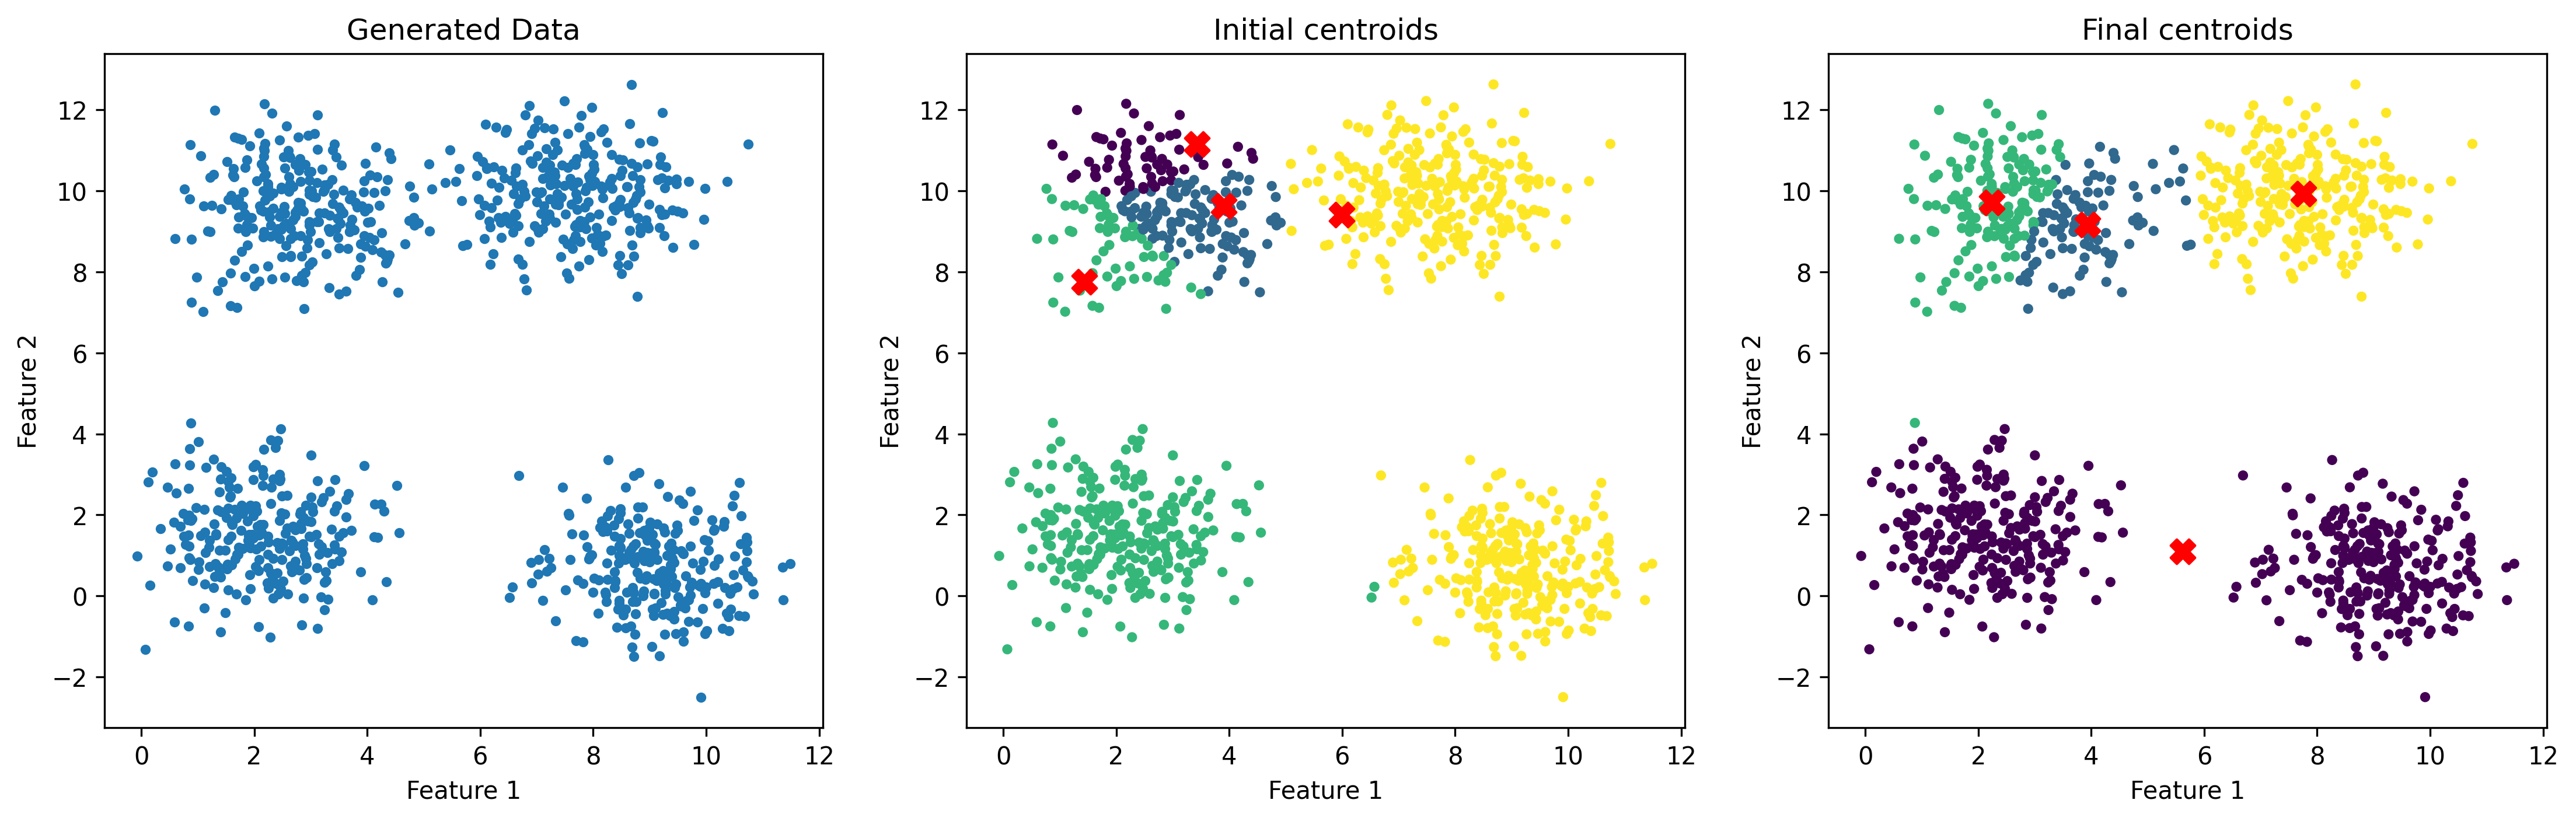

In [15]:
data = generate_data(n_samples=1000, n_features=2, n_clusters=4, random_state=31)

# first plot initial centroids. Then proceed with my k-means implementation and plot resulting centroids
np.random.seed(379)
kmeans = KMeans(algorithm='lloyd', init='random')
kmeans.data = data
kmeans.n_samples = data.shape[0]
kmeans.k = 4
kmeans._init_centroids()

fig, ax = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

ax[0].scatter(data[:, 0], data[:, 1], s=10)
ax[0].set_title('Generated Data')
ax[0].set_xlabel('Feature 1')
ax[0].set_ylabel('Feature 2')

ax[1].scatter(data[:, 0], data[:, 1], c=kmeans.y_pred, cmap='viridis', s=10)
ax[1].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', s=100, marker='X')
ax[1].set_title('Initial centroids')
ax[1].set_xlabel('Feature 1')
ax[1].set_ylabel('Feature 2')

np.random.seed(379)
kmeans = KMeans(algorithm='lloyd', init='random')
kmeans.fit(data, 4, debug=0)

ax[2].scatter(data[:, 0], data[:, 1], c=kmeans.y_pred, cmap='viridis', s=10)
ax[2].scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', s=100, marker='X')
ax[2].set_title('Final centroids')
ax[2].set_xlabel('Feature 1')
ax[2].set_ylabel('Feature 2')

plt.show()
